# **Online Recommender System Prototype (OTTO Dataset)**

This notebook documents an experimental MVP developed by the data science team to explore feasible recommendation strategies using the OTTO RecSys dataset as a proxy for customer data.
The objective is to validate lightweight, production-aligned methods that address three key functional requirements commonly found in e-commerce systems:

* **Top-Seller Recommendations** driven by recency-weighted popularity
* **Frequently Bought Together (FreBoTo)** signals derived from session-level co-visitation
* **Real-Time Session-Based Recommendations** combining behavioral co-occurrence, semantic similarity, and global demand patterns

The prototype focuses on practicality and end-to-end operability: scalable ingestion, exploratory analysis, chronological evaluation, model construction, artifact generation, and real-time serving considerations are all included to support future integration into a production environment.


# **1. Project Context & Requirements**

This prototype is developed as an MVP to demonstrate how an e-commerce platform can deliver relevant product recommendations using only behavioral session data.
The customer’s production data is not yet available, so the team uses the OTTO RecSys dataset as a realistic substitute that mirrors large-scale online retail interactions.

The goal is to validate whether a lightweight, scalable recommendation stack can address three core functional needs:

### **• Top-Seller Recommendations**

Surface globally popular products based on implicit feedback patterns.
This forms a stable fallback layer and supports generic merchandising use cases.

### **• Frequently Bought Together (FreBoTo)**

Identify items that co-occur meaningfully within user sessions.
This enables basket-building recommendations and complementary product suggestions.

### **• Real-Time Session-Based Recommendations**

Generate next-item predictions using the user’s recent interactions.
This requires low-latency scoring, small memory footprint, and no dependence on heavy model retraining.

---

### **Technical constraints shaping the prototype**

* Only **implicit behavioral events** (clicks, carts, orders) are available.
* No user profiles or product metadata exist — modeling must be **session-based and item-only**.
* The solution must execute end-to-end within a **single notebook environment**.
* Similar to a real pipeline, the system should support:

  * scalable ingestion,
  * chronological validation,
  * artifact versioning,
  * and real-time serving feasibility.

---

### **Target outcome**

The MVP should deliver:

1. A functioning set of recommenders for the three tasks
2. Clear evaluation on time-split validation and held-out test sessions
3. A realistic proposal for how these components could be deployed
4. Persisted artifacts suitable for later integration into an API or batch pipeline

# **2. Dataset Overview**

The OTTO RecSys dataset serves as the behavioral foundation for this MVP.
It contains large-scale, session-based interaction logs collected from a real e-commerce platform over a multi-week period and mirrors the patterns expected in modern retail environments.

### **2.1 Data Structure**

Each record represents an entire user session:

```json
{
  "session": <session_id>,
  "events": [
     {"aid": <item_id>, "ts": <timestamp_ms>, "type": "clicks"},
     {"aid": <item_id>, "ts": <timestamp_ms>, "type": "carts"},
     {"aid": <item_id>, "ts": <timestamp_ms>, "type": "orders"}
  ]
}
```

Where:

* **session** — anonymized session identifier
* **aid** — anonymized product identifier
* **ts** — timestamp in milliseconds
* **type** — one of `"clicks"`, `"carts"`, `"orders"`

Events are generally chronological, but explicit sorting is advised for correctness.

---

### **2.2 Dataset Scale and Characteristics**

Training split:

* **~12.9M sessions**
* **~220M events**
* **~1.86M unique items**
* Average session length: **~17 events**
* Event breakdown:

  * clicks ≈ 81.5%
  * carts ≈ 10.3%
  * orders ≈ 8.2%

Test split:
~1.67M sessions without ground-truth labels.

This scale provides a realistic foundation for both offline modeling and real-time recommendation experiments.

---

## **2.3 Pros of the Dataset (Strengths for Our MVP)**

### **Rich behavioral signal**

The large volume of interactions enables strong signals for:

* popularity estimation
* co-visitation patterns
* embedding-based similarity

### **Session-oriented structure**

Sessions are self-contained and ordered, making the data naturally suited for:

* next-item prediction
* short-term intent modeling
* context-aware recommendations

### **Event hierarchy**

The click → cart → order funnel provides graded implicit feedback, helpful for:

* weighted frequency models
* importance scoring in co-visitation
* fine-grained recency weighting

### **High item diversity (~1.8M items)**

This encourages hybrid methods that combine:

* global popularity
* co-occurrence statistics
* semantic embedding vectors

### **Temporal separation**

OTTO provides a 4-week train + 1-week test split, which supports:

* chronological validation
* drift analysis
* real-world generalization checks

---

## **2.4 Potential Issues (Points to Watch Closely)**

### **No persistent user identifiers**

Only session-level data is available.
This limits:

* long-term personalization
* cross-session modeling
* user-level collaborative filtering

### **No product metadata**

No categories, descriptions, pricing, or attributes.
All modeling must be driven by:

* behavior
* sequence patterns
* item IDs only

### **Extreme item sparsity**

Many items appear only a handful of times.
This affects:

* embedding quality for long-tail items
* coverage for nearest-neighbor searches
* cold-start behavior

### **Implicit feedback only**

There are no explicit ratings or dwell times.
Interpretation depends on:

* interaction types
* recency
* frequency patterns

### **Heavy click dominance (~80%)**

Clicks may overwhelm more meaningful signals without proper weighting.

### **Test labels unavailable**

The test set contains sessions with missing final target events.
Reconstruction of next-item predictions requires special handling.


In [2]:
# Additional Installs needed
!pip install duckdb
!pip install faiss-cpu

In [3]:
# Imports

import json
from pathlib import Path
from typing import List, Dict, Tuple, Iterator, Optional, Any
import numpy as np
import pandas as pd
import pickle
from collections import Counter, defaultdict
import pyarrow.parquet as pq
import pyarrow as pa
import gc
import duckdb
from gensim.models import Word2Vec
import faiss

from dataclasses import dataclass, asdict, field
import uuid
import platform
import datetime
import sys
import matplotlib.pyplot as plt

# **3. Global Configuration**

The configuration block below collects all parameters that control the behavior of the experiment.
Values are grouped by purpose to keep the setup modular and easy to adjust.

* **Ingestion** — controls JSONL streaming, chunk sizes, and preprocessing limits
* **Train/Validation Split** — defines the chronological ratio for next-event evaluation
* **Evaluation** — top-K cutoff, session window size, and optional limits for fast iteration
* **Popularity Model** — event-type weights and recency decay settings
* **Co-Visitation Model** — time window, per-session limits, and neighbor count
* **Item2Vec** — embedding dimension, context window, negative samples, epochs
* **Hybrid Model** — weight distribution across co-visitation, embeddings, and popularity
* **Run Manifest** — container for configuration snapshots, metrics, and artifact paths

In [4]:
# ===============================================================
# Global Configuration
# ===============================================================

# ==============================================================================
# 1. Paths / Data Layout
# ==============================================================================

DATA_DIR      = Path("../data")
ARTIFACT_DIR  = Path("../models")

RAW_DIR       = DATA_DIR / "raw"
PROC_DIR      = DATA_DIR / "processed"

RAW_TRAIN_PATH = RAW_DIR / "otto-recsys-train.jsonl"
RAW_TEST_PATH  = RAW_DIR / "otto-recsys-test.jsonl"

TRAIN_CHUNK_DIR = PROC_DIR / "train_chunks"
TEST_CHUNK_DIR  = PROC_DIR / "test_chunks"

# Optional consolidated parquet tables (if you ever write them)
TRAIN_EVENTS_PATH = PROC_DIR / "train_events.parquet"
TEST_EVENTS_PATH  = PROC_DIR / "test_events.parquet"

# DuckDB main database for processed events
DUCKDB_PATH = PROC_DIR / "events.duckdb"

# Per-model subdirectories inside the run-specific artifact repo
ITEM2VEC_SUBDIR = "item2vec"


# ==============================================================================
# 2. Ingestion & Cleaning
# ==============================================================================

CHUNKSIZE              = 50_000     # sessions per JSONL chunk
MIN_EVENTS_PER_SESSION = 2          # drop single-event sessions
SORT_EVENTS            = True       # enforce (session, ts) order


# ==============================================================================
# 3. Notebook Convenience (DEV ONLY)
#    These allow faster iteration during development.
#    Leave set to None for production or full training.
# ==============================================================================

# Cap rows loaded into memory during EDA
MAX_TRAIN_ROWS_SAMPLE = None    # None = full dataset

# Validation subsampling
EVAL_MAX_SESSIONS = None             # None = evaluate all val sessions

# Item2Vec training subsample
MAX_SESSIONS_FOR_W2V = None         # None = full dataset


# ==============================================================================
# 4. Event Semantics
# ==============================================================================

EVENT_WEIGHTS = {
    "clicks": 1.0,
    "carts":  3.0,
    "orders": 5.0,
}

# Internal compact encoding for event types
EVENT_TYPE_TO_ID = {"clicks": 0, "carts": 1, "orders": 2}
EVENT_ID_TO_TYPE = {v: k for k, v in EVENT_TYPE_TO_ID.items()}
EVENT_TYPE_DTYPE = np.int8


# ==============================================================================
# 5. Evaluation Settings
# ==============================================================================

TOP_K            = 20     # number of recommendations returned
EVAL_MAX_HISTORY = 5      # how many last events of session to use


# ==============================================================================
# 6. Popularity / Top-Sellers
# ==============================================================================

RECENCY_DECAY_LAMBDA = 0.01
MAX_POPULARITY_ITEMS = 10_000


# ==============================================================================
# 7. Co-Visitation
# ==============================================================================

# --- Build-time parameters ---
COVIS_SESSION_LIMIT     = 20               # events per session window
COVIS_TOPK              = 40               # neighbors stored per item
COVIS_MAX_TIME_MS       = 12 * 60 * 60 * 1000
COVIS_TIME_DECAY_LAMBDA = 0.05

# --- Inference-time parameters ---
COVIS_MAX_HISTORY  = 10     # how many last items from session to use
COVIS_RECENCY_BASE = 0.9    # recency decay per step into the past


# ==============================================================================
# 8. Item2Vec
# ==============================================================================

# Training
ITEM2VEC_EMBED_DIM  = 32
ITEM2VEC_WINDOW     = 3
ITEM2VEC_MIN_COUNT  = 5
ITEM2VEC_NEGATIVE   = 3
ITEM2VEC_EPOCHS     = 3
ITEM2VEC_BATCH_SIZE = 50_000
ITEM2VEC_WORKERS    = 4

# Inference
CONTEXT_LEN = 5


# ==============================================================================
# Hybrid Recommender
# ==============================================================================

HYBRID_W_COVIS    = 0.6
HYBRID_W_ITEM2VEC = 0.25
HYBRID_W_POP      = 0.15
HYBRID_CAND_MULT  = 2


# ==============================================================================
# Reproducibility
# ==============================================================================

RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

MODEL_VERSION = "1.0"



## **Experiment Manifest (Run Metadata & Artifacts)**

This section initializes the experiment manifest used to track all metadata associated with the current run.
The manifest acts as a lightweight record-keeping layer and helps maintain reproducibility as the team iterates on the MVP.

The manifest captures:

* **Run identity** — a unique run ID, model version, and creation timestamp
* **Data references** — paths to the DuckDB database and the tables used for training, validation, and test
* **Configuration snapshot** — all relevant hyperparameters and model settings
* **Metrics** — evaluation results for each model across validation and test splits
* **Artifacts** — files generated during the experiment (e.g., co-visitation index, Item2Vec vectors, FAISS index, popularity tables), each logged with metadata
* **Environment info** — Python version, platform, and other system details

The manifest also provides convenience methods for logging metrics, registering artifacts, and serializing the full record to disk.
Each experiment run receives its own artifact directory, ensuring that models, indexes, and metadata remain organized and isolated from previous runs.

This structure is intended to support later integration into automated pipelines or model registries while keeping the MVP simple and transparent.


In [5]:
# ===============================================================
# Experiment Manifest (Run Metadata & Artifacts)
# ===============================================================

@dataclass
class ArtifactInfo:
    name: str               # logical name, e.g. "covis_neighbors_index"
    path: str               # relative path under ARTIFACT_DIR
    kind: str               # e.g. "parquet", "pickle", "npy", "json"
    description: str = ""
    metadata: Dict[str, Any] = field(default_factory=dict)

@dataclass
class ExperimentManifest:
    run_id: str
    model_version: str
    artifact_repo: str
    created_at: str
    data: Dict[str, Any]
    config: Dict[str, Any]
    metrics: Dict[str, Dict[str, Any]] = field(default_factory=dict)
    artifacts: List[ArtifactInfo] = field(default_factory=list)
    env: Dict[str, Any] = field(default_factory=dict)

    # --- Artifact helpers ---
    def add_artifact(
        self,
        name: str,
        path: Path,
        kind: str,
        description: str = "",
        metadata: Optional[Dict[str, Any]] = None,
    ):
        rel_path = path.name  # we store file name relative to ARTIFACT_DIR
        self.artifacts.append(
            ArtifactInfo(
                name=name,
                path=rel_path,
                kind=kind,
                description=description,
                metadata=metadata or {},
            )
        )

    # --- Metrics helpers ---
    def log_metrics(self, split: str, metrics: Dict[str, Any]):
        """
        split: e.g. "validation", "test"
        metrics: {"popularity": {...}, "covis": {...}, ...}
        """
        self.metrics[split] = metrics

    # --- Single Metric helper ---
    def add_metric(self, split: str, model_name: str, value: Dict[str, Any]):
        if split not in self.metrics:
            self.metrics[split] = {}
        if model_name not in self.metrics[split]:
            self.metrics[split][model_name] = {}
        self.metrics[split][model_name] = value

    # --- Serialize to disk ---
    def save(self, filename: str = "manifest.json"):
        manifest_dict = asdict(self)

        # convert repo string → Path
        repo_path = Path(self.artifact_repo)

        out_path = repo_path / filename
        with out_path.open("w") as f:
            json.dump(manifest_dict, f, indent=2)
        print(f"[Manifest] Saved to {out_path}")


def get_default_env_info() -> Dict[str, Any]:
    return {
        "python_version": sys.version.split()[0],
        "platform": platform.platform(),
        "timestamp_utc": datetime.datetime.utcnow().isoformat() + "Z",
    }


# ===============================================================
# Initialize global RUN_MANIFEST
# ===============================================================

RUN_ID = str(uuid.uuid4())[:8]  # short id for this notebook run

RUN_FOLDER_NAME = f"{MODEL_VERSION}__{RUN_ID}"

# This is the per-experiment directory for all artifacts + manifest
ARTIFACT_REPO = ARTIFACT_DIR / RUN_FOLDER_NAME
ARTIFACT_REPO.mkdir(parents=True, exist_ok=True)

print(f"[Artifacts] Repo: {ARTIFACT_DIR}")
print(f"[Artifacts] Run dir: {ARTIFACT_REPO}")

RUN_MANIFEST = ExperimentManifest(
    run_id=RUN_ID,
    model_version=MODEL_VERSION,
    artifact_repo=str(ARTIFACT_REPO),
    created_at=datetime.datetime.utcnow().isoformat() + "Z",
    data={
        "duckdb_path": str(DUCKDB_PATH),
        "train_table": "events_train_split",
        "val_table":   "events_val_split",
        "test_table":  "events_test",
    },
    config={
        "TOP_K": TOP_K,
        "RECENCY_DECAY_LAMBDA": RECENCY_DECAY_LAMBDA,
        "MAX_POPULARITY_ITEMS": MAX_POPULARITY_ITEMS,
        "COVIS_SESSION_LIMIT": COVIS_SESSION_LIMIT,
        "COVIS_TOPK": COVIS_TOPK,
        "COVIS_MAX_TIME_MS": COVIS_MAX_TIME_MS,
        "COVIS_TIME_DECAY_LAMBDA": COVIS_TIME_DECAY_LAMBDA,
        "ITEM2VEC_EMBED_DIM": ITEM2VEC_EMBED_DIM,
        "ITEM2VEC_WINDOW": ITEM2VEC_WINDOW,
        "ITEM2VEC_MIN_COUNT": ITEM2VEC_MIN_COUNT,
        "ITEM2VEC_NEGATIVE": ITEM2VEC_NEGATIVE,
        "ITEM2VEC_EPOCHS": ITEM2VEC_EPOCHS,
        "CONTEXT_LEN": CONTEXT_LEN,
        "HYBRID_W_COVIS": HYBRID_W_COVIS,
        "HYBRID_W_ITEM2VEC": HYBRID_W_ITEM2VEC,
        "HYBRID_W_POP": HYBRID_W_POP,
    },
    env=get_default_env_info(),
)

RUN_MANIFEST.save()
print(f"[Manifest] Initialized run_id={RUN_ID}, model_version={MODEL_VERSION}")


[Artifacts] Repo: ../models
[Artifacts] Run dir: ../models/1.0__f6843aa7
[Manifest] Saved to ../models/1.0__f6843aa7/manifest.json
[Manifest] Initialized run_id=f6843aa7, model_version=1.0


#### A simple memory cleaner helper

In [6]:
# Global helpers
def clean_memory(vars_to_delete=None, delete_all_dfs=False, verbose=True):
    """
    Clean up heavy variables and free memory in a notebook environment.

    Args:
        vars_to_delete (list[str], optional):
            A list of variable names (as strings) to delete from globals().

        delete_all_dfs (bool, optional):
            If True, automatically delete all pandas DataFrames found in globals().

        verbose (bool, optional):
            Print which variables were deleted.

    Usage:
        clean_memory(["train_events", "eda_sample"])
        clean_memory(delete_all_dfs=True)
    """
    deleted = []

    # 1. Delete specific variables by name
    if vars_to_delete:
        for var in vars_to_delete:
            if var in globals():
                del globals()[var]
                deleted.append(var)

    # 2. Delete all DataFrames automatically
    if delete_all_dfs:
        for name, val in list(globals().items()):
            if isinstance(val, pd.DataFrame):
                del globals()[name]
                deleted.append(name)

    # 3. Garbage collection
    gc.collect()

    if verbose:
        if deleted:
            print("Deleted variables:", ", ".join(deleted))
        else:
            print("No matching variables deleted.")
        print("Garbage collection complete.")

# **4. Data Ingestion & Cleaning (ETL job)**

This section handles the conversion of the original JSONL session files into a flattened event-level format suitable for analysis and modeling.
The ingestion pipeline uses a streaming approach to remain memory-efficient at OTTO scale and ensures consistent ordering and schema across all generated data.

### **Process Overview**

* Read the raw JSONL file in **streaming batches**
* Flatten session records into individual event rows
* Normalize types and enforce a consistent schema
* Sort events by `session` and `timestamp`
* Write results into **parquet chunks** for efficient downstream access
* Register the ingested parquet data as DuckDB base tables

### **Outputs**

* `train_chunks/` — parquet files containing all training events
* `test_chunks/` — parquet files containing all test events
* DuckDB tables:

  * `events_train`
  * `events_test`

These tables serve as the foundation for EDA, splitting, feature extraction, and all subsequent modeling steps.

In [7]:
# --- [DEV ONLY] Ingestion / cleaning overrides ---
# CHUNKSIZE             = 50_000
# MIN_EVENTS_PER_SESSION = 2
# SORT_EVENTS            = True

In [8]:
def stream_flatten_and_clean_jsonl_to_parquet_chunks(
    jsonl_path: Path,
    out_dir: Path,
    chunksize: int = 100_000,
    compress: str = "snappy",
    min_events_per_session: int = 2,
    sort_events: bool = True,
) -> List[Path]:
    """
    Stream `jsonl_path` (one session per line), flatten sessions to events,
    optionally sort by (session, ts), drop short sessions, enforce dtypes and
    write each processed chunk to `out_dir` as a parquet file.

    Returns:
        List of written parquet file paths.

    Notes:
    - Memory friendly: never holds more than `chunksize` sessions in memory.
    - Assumes each line in the JSONL is a complete session (OTTO format).
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    written_paths: List[Path] = []

    def _process_batch(batch: List[Dict], batch_idx: int) -> Path | None:
        """Flatten + clean one batch of sessions and write a parquet chunk."""
        if not batch:
            return None

        # sessions -> DataFrame
        df_sessions = pd.DataFrame(batch)

        # explode events and re-attach session id
        exploded = df_sessions.explode("events").reset_index(drop=True)

        # if there are no events (edge case), skip
        if exploded["events"].isna().all():
            return None

        event_cols = pd.json_normalize(exploded["events"])
        events = pd.concat(
            [exploded[["session"]].reset_index(drop=True), event_cols],
            axis=1,
        )

        # keep only the expected columns
        events = events[["session", "aid", "ts", "type"]]

        # drop sessions with too few events
        if min_events_per_session is not None and min_events_per_session > 1:
            session_counts = events.groupby("session")["aid"].transform("count")
            events = events[session_counts >= min_events_per_session].reset_index(drop=True)

        if events.empty:
            return None

        # optional sort by (session, ts) to guarantee temporal order
        if sort_events:
            events = events.sort_values(["session", "ts"]).reset_index(drop=True)

        # enforce compact dtypes
        events["session"] = events["session"].astype("int64")
        events["aid"] = events["aid"].astype("int64")
        events["ts"] = events["ts"].astype("int64")
        events["type"] = events["type"].astype("category")

        out_path = out_dir / f"events_part_{batch_idx:05d}.parquet"
        events.to_parquet(out_path, index=False, compression=compress)
        return out_path

    with jsonl_path.open("r") as f:
        batch: List[Dict] = []
        batch_idx = 0

        for i, line in enumerate(f):
            line = line.strip()
            if not line:
                continue

            batch.append(json.loads(line))

            # process when batch is full
            if len(batch) >= chunksize:
                out_path = _process_batch(batch, batch_idx)
                if out_path is not None:
                    written_paths.append(out_path)

                batch = []
                batch_idx += 1

                if batch_idx % 5 == 0:
                    print(
                        f"[stream_flatten] processed ~{(batch_idx * chunksize):,} sessions, "
                        f"chunks written: {len(written_paths)}"
                    )

        # flush remaining sessions in final batch
        if batch:
            out_path = _process_batch(batch, batch_idx)
            if out_path is not None:
                written_paths.append(out_path)

    print(f"[stream_flatten] done. Total chunks written: {len(written_paths)} "
          f"to directory: {out_dir}")
    return written_paths

def stream_train_event_chunks(
    chunk_dir: Path,
    columns: Optional[List[str]] = None,
) -> Iterator[pd.DataFrame]:
    """
    Iterate parquet chunk files in `chunk_dir`, yielding one DataFrame per file.

    Use this when you want to process the full dataset (or most of it)
    in a streaming fashion without loading everything into memory.
    """
    files = sorted(chunk_dir.glob("*.parquet"))
    for p in files:
        yield pd.read_parquet(p, columns=columns)


def load_train_events(
    chunk_dir: Path,
    columns: Optional[List[str]] = None,
    max_rows: Optional[int] = None,
    train_path: Optional[Path] = None
) -> pd.DataFrame:
    """
    Load training events into a single pandas DataFrame for use in the notebook.

    Priority:
    1) If `train_path` is provided AND exists, load from that single parquet file.
    2) Otherwise, read and concatenate parquet chunks from `chunk_dir`.

    Args:
        chunk_dir: Directory containing parquet chunk files (output of the streaming ingestion).
        train_path: Optional path to a consolidated parquet file (if you chose to create one).
        columns: Optional list of columns to load.
        max_rows: Optional cap on the number of rows to load (useful to avoid OOM).

    Returns:
        Pandas DataFrame with up to `max_rows` rows (if specified).
    """
    # 1) Prefer a consolidated file if provided and exists
    if train_path is not None and train_path.exists():
        df = pd.read_parquet(train_path, columns=columns)
        if max_rows:
            df = df.head(max_rows)
        return df.reset_index(drop=True)

    # 2) Fallback: load from chunk directory
    if not chunk_dir.exists():
        raise FileNotFoundError(
            f"Neither consolidated file `{train_path}` nor chunk dir `{chunk_dir}` exist"
        )

    dfs = []
    rows_acc = 0

    for chunk_df in stream_train_event_chunks(chunk_dir, columns=columns):
        if max_rows is not None:
            remaining = max_rows - rows_acc
            if remaining <= 0:
                break
            chunk_df = chunk_df.head(remaining)

        dfs.append(chunk_df)
        rows_acc += len(chunk_df)

        if max_rows is not None and rows_acc >= max_rows:
            break

    if not dfs:
        # Empty fallback with canonical columns
        return pd.DataFrame(columns=columns or ["session", "aid", "ts", "type"])

    df = pd.concat(dfs, ignore_index=True)
    return df.reset_index(drop=True)


In [9]:
PROC_DIR.mkdir(parents=True, exist_ok=True)

written_train = stream_flatten_and_clean_jsonl_to_parquet_chunks(RAW_TRAIN_PATH, TRAIN_CHUNK_DIR, chunksize=CHUNKSIZE)
written_test  = stream_flatten_and_clean_jsonl_to_parquet_chunks(RAW_TEST_PATH,  TEST_CHUNK_DIR,  chunksize=CHUNKSIZE)

print(f"Train chunks written: {len(written_train)} files -> {TRAIN_CHUNK_DIR}")
print(f"Test chunks written:  {len(written_test)} files -> {TEST_CHUNK_DIR}")


[stream_flatten] processed ~250,000 sessions, chunks written: 5
[stream_flatten] processed ~500,000 sessions, chunks written: 10
[stream_flatten] processed ~750,000 sessions, chunks written: 15
[stream_flatten] processed ~1,000,000 sessions, chunks written: 20
[stream_flatten] processed ~1,250,000 sessions, chunks written: 25
[stream_flatten] processed ~1,500,000 sessions, chunks written: 30
[stream_flatten] processed ~1,750,000 sessions, chunks written: 35
[stream_flatten] processed ~2,000,000 sessions, chunks written: 40
[stream_flatten] processed ~2,250,000 sessions, chunks written: 45
[stream_flatten] processed ~2,500,000 sessions, chunks written: 50
[stream_flatten] processed ~2,750,000 sessions, chunks written: 55
[stream_flatten] processed ~3,000,000 sessions, chunks written: 60
[stream_flatten] processed ~3,250,000 sessions, chunks written: 65
[stream_flatten] processed ~3,500,000 sessions, chunks written: 70
[stream_flatten] processed ~3,750,000 sessions, chunks written: 75
[s

In [10]:
# Build / refresh DuckDB base tables from parquet chunks

# Ensure we have a fresh connection (optional, but explicit)
con = duckdb.connect(str(DUCKDB_PATH))

def create_events_table_query(name, chunk_dir):
    return f"""
        CREATE TABLE {name} AS
        SELECT
            CAST(session AS BIGINT) AS session,
            CAST(aid     AS BIGINT) AS aid,
            CAST(ts      AS BIGINT) AS ts,
            CAST(type    AS VARCHAR) AS type
        FROM read_parquet('{chunk_dir.as_posix()}/*.parquet')
    """

# Training dataset table

# Drop existing table if re-running
con.execute("DROP TABLE IF EXISTS events_train")
# Create events_train table reading directly from parquet
con.execute(create_events_table_query("events_train", TRAIN_CHUNK_DIR))

# Test dataset table
# Drop existing table if re-running
con.execute("DROP TABLE IF EXISTS events_test")
# Create events_train table reading directly from parquet
con.execute(create_events_table_query("events_test", TEST_CHUNK_DIR))

# Quick sanity check
con.execute("SELECT COUNT(*) AS n_events, COUNT(DISTINCT session) AS n_sessions FROM events_train").df()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_events,n_sessions
0,216716096,12899779




# **5. Exploratory Data Analysis (EDA)**

**Focus areas:**

* Dataset size and sparsity
* Click/cart/order distribution
* Session length and item diversity
* Item frequency and long-tail behavior
* Basic temporal patterns

**Outcome:**
A data-grounded understanding of the interaction patterns that guide the modeling choices in subsequent sections.

In [11]:
# --- [DEV ONLY] EDA overrides ---
# MAX_TRAIN_ROWS_SAMPLE = 500_000

#### Global Dataset Size (Full Dataset via DuckDB)

Total number of events, sessions, and unique items in the dataset.
This gives a high-level understanding of dataset scale and helps guide modeling choices such as memory constraints, algorithm selection, and sampling strategy.


In [12]:
# Count total events, sessions, items from full dataset
global_stats = con.execute("""
    SELECT
        (SELECT COUNT(*)                 FROM events_train) AS n_events,
        (SELECT COUNT(DISTINCT session)  FROM events_train) AS n_sessions,
        (SELECT COUNT(DISTINCT aid)      FROM events_train) AS n_items
""").df()

global_stats


,n_events,n_sessions,n_items
0,216716096,12899779,1855603


#### Notes

- **Implications for modeling:**
  - **Co-visitation matrices:**
    The high number of sessions provides strong co-occurrence signal, but memory-efficient chunking and pruning are needed.
  - **Item2Vec:**
    With ~1.8M items, embeddings must be compact (e.g., 32–64 dimensions) to avoid memory explosion.
  - **Popularity models:**
    Large event volume produces stable popularity distributions; recency weighting becomes important to capture trends.
  - **Real-time recommendations:**
    System must support high-cardinality item space → favors approximate nearest neighbors or pruned candidate sets.
  - **EDA strategy:**
    Full-data interactions should be analyzed via DuckDB; pandas operations must rely on sampling.


#### Event-Type Distribution

Distribution of interaction types—clicks, carts, and orders—across the full dataset.
This reveals user behavior patterns and the relative strength of different interaction signals.

In [13]:
# Event-type distribution (full dataset)
event_type_stats = con.execute("""
    SELECT type,
           COUNT(*) AS count,
           COUNT(*) * 1.0 / (SELECT COUNT(*) FROM events_train) AS ratio
    FROM events_train
    GROUP BY type
    ORDER BY count DESC
""").df()

event_type_stats


,type,count,ratio
0,clicks,194720954,0.898507
1,carts,16896191,0.077965
2,orders,5098951,0.023528


#### Notes

- Clicks represent the overwhelming majority of events (~90%), followed by carts (~8%) and orders (~2%).
- This **funnel shape** is typical for e-commerce platforms and confirms:
  - Clicks carry broad interest but are noisy and abundant.
  - Carts and orders provide stronger intent but are significantly rarer.
- For modeling:
  - **Event weighting** is justified (click < cart < order) for popularity and co-visitation scoring.
  - **Co-visitation** will be dominated by clicks unless event-type weights or filtering are applied.
  - **Item2Vec** benefits from clicks for training volume, but deeper signals (cart/order) help capture true semantic relationships.
- The imbalance supports a design where:
  - Clicks drive early-session relevance.
  - Carts/orders reinforce high-quality recommendations.
  - Hybrid models balance coverage vs precision.

This distribution validates the weighted interaction approach used later in the notebook.


#### Session Length Distribution

Distribution of session lengths across the full dataset.
Understanding how many events typically occur within a session helps guide the design of co-visitation, next-event prediction, and real-time recommendation logic.


In [14]:
# Session length distribution (full percentile metrics)
session_len_stats = con.execute("""
    WITH lens AS (
        SELECT session, COUNT(*) AS len
        FROM events_train
        GROUP BY session
    )
    SELECT
        AVG(len) AS avg_len,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY len) AS p50,
        PERCENTILE_CONT(0.9) WITHIN GROUP (ORDER BY len) AS p90,
        PERCENTILE_CONT(0.99) WITHIN GROUP (ORDER BY len) AS p99
    FROM lens
""").df()

session_len_stats

,avg_len,p50,p90,p99
0,16.799985,6.0,39.0,176.0


#### Notes

- The **average session contains ~17 events**, with a median of 6, showing that most sessions are short while a minority are very long.
- The **90th percentile at 39 events** and **99th percentile at 176 events** reflect a heavy-tailed distribution:
  - A few users engage deeply within their sessions.
  - Most sessions provide only limited actionable signal.

- **Modeling implications:**
  - **Co-visitation:**
    Works well because many sessions include multiple interactions, but must be pruned to avoid combinatorial explosion in long sessions.
  - **Real-time recommendations:**
    Using the last *N* events (e.g., last 5) is justified because median sessions are short.
  - **Item2Vec:**
    Longer sessions provide rich sequences that help embedding training.
  - **Evaluation:**
    Care must be taken not to overfit rare, very long sessions—they do not represent typical user behavior.

This distribution supports a hybrid recommendation approach balancing short-session robustness with the ability to learn from richer long sessions.

#### Item Frequency Distribution

Item-level interaction frequencies across the full dataset.
This reveals how often different items appear in sessions and helps assess the degree of long-tail behavior in the catalog.

In [15]:
# Item frequency distribution (percentiles from full data)
item_freq_stats = con.execute("""
    WITH freq AS (
        SELECT aid, COUNT(*) AS c
        FROM events_train
        GROUP BY aid
    )
    SELECT
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY c)  AS p50,
        PERCENTILE_CONT(0.9) WITHIN GROUP (ORDER BY c)  AS p90,
        PERCENTILE_CONT(0.99) WITHIN GROUP (ORDER BY c) AS p99,
        AVG(c) AS avg_freq
    FROM freq
""").df()

item_freq_stats

,p50,p90,p99,avg_freq
0,20.0,183.0,1678.0,116.790119


#### Notes

- Item interaction frequencies show a **strong long-tail distribution**:
  - Half of all items appear **20 times or fewer**.
  - 90% of items appear fewer than **183 times**.
  - Only the top 1% of items exceed **1,678 interactions**.
- The average frequency (~117) is pulled upward by a small number of very popular items.

- **Modeling implications:**
  - **Long-tail challenge:**
    Many items have sparse interactions → pure frequency-based methods (like simple popularity) struggle with coverage.
  - **Co-visitation:**
    Benefits from multi-item sessions but still requires pruning, since low-frequency items offer limited co-occurrence signal.
  - **Item2Vec embeddings:**
    Essential to help generalize beyond raw counts and capture semantic similarity for rare items.
  - **Hybrid recommender design:**
    A fallback popularity model is useful, but embeddings and co-visitation are needed to handle less frequent items effectively.

This distribution validates a mixed strategy combining popularity, co-visitation, and representation learning to cover both head and tail items.

**Event timeline coverage**
Helps understand recency, trends, or possible drift. You already use timestamps later for drift; this makes it explicit in EDA.
Shows total time window covered by data; co-vis and item2vec heavily depend on time span.

#### Event Timeline Coverage

We compute the minimum and maximum timestamps in the full dataset to understand the temporal span of user interactions.
This reveals how many days of activity the dataset represents and helps interpret recency effects and drift sensitivity.

In [16]:
# Event timeline coverage
event_timeline_cov = con.execute("""
    SELECT
        MIN(ts) AS min_ts,
        MAX(ts) AS max_ts,
        (MAX(ts) - MIN(ts)) / (1000*60*60*24) AS days_span
    FROM events_train;
""").df()

event_timeline_cov

,min_ts,max_ts,days_span
0,1659304800025,1661723999984,28.0


#### Notes

- The dataset spans **28 days** of user activity, from the earliest to the latest timestamp.
- A ~1-month window suggests:
  - Interaction patterns may reflect short-term trends (e.g., promotions, seasonality).
  - Recency weighting (e.g., exponential decay) is useful when computing popularity scores.
  - Drift detection between train and validation splits is meaningful over this timeframe.

- **Modeling implications:**
  - **Popularity models:** Should incorporate recency, since item demand can shift quickly within a month.
  - **Co-visitation:** Temporal proximity of events remains relevant; co-vis patterns likely represent fresh behavioral co-occurrence.
  - **Session-based next-item prediction:** Works well because the dataset covers a compact time window where item context remains consistent.
  - **Evaluation:** A time-based train/validation split is appropriate and reflects real-world temporal generalization.

Understanding the dataset’s time span helps ensure that models capture short-term signals while remaining robust to trend shifts.


Event volume pr day

#### Daily Event Volume

We aggregate the number of events per day across the full dataset to understand temporal activity patterns.
This helps identify periodic trends, peak usage days, and potential sources of temporal drift.

In [17]:
event_volume = con.execute("""
    SELECT
        DATE(TIMESTAMP 'epoch' + ts/1000 * INTERVAL '1 second') AS day,
        COUNT(*) AS events
    FROM events_train
    GROUP BY 1
    ORDER BY 1;
""").df()

event_volume

,day,events
0,2022-07-31,349112
1,2022-08-01,7609906
2,2022-08-02,7514825
3,2022-08-03,7962588
4,2022-08-04,7667421
5,2022-08-05,7083114
6,2022-08-06,6915545
7,2022-08-07,8352878
8,2022-08-08,6799534
9,2022-08-09,7988795


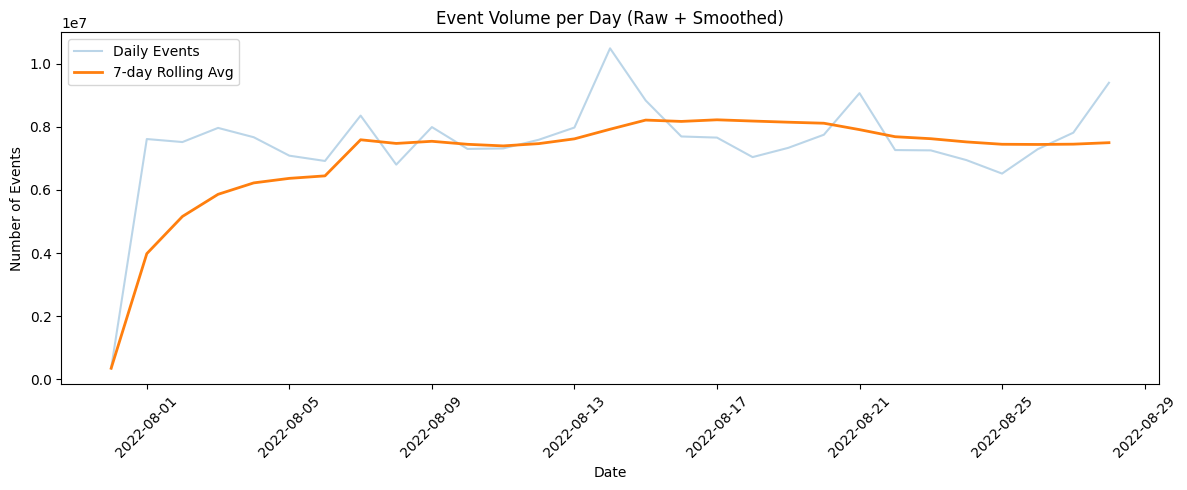

In [18]:
plt.figure(figsize=(12,5))

plt.plot(event_volume["day"], event_volume["events"], alpha=0.3, label="Daily Events")
plt.plot(event_volume["day"],
         event_volume["events"].rolling(7, min_periods=1).mean(),
         label="7-day Rolling Avg", linewidth=2)

plt.title("Event Volume per Day (Raw + Smoothed)")
plt.xlabel("Date")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#### Notes

- The dataset exhibits **clear daily activity patterns**, with event volumes typically in the 6–10 million range.
- Sundays (e.g., 2022-08-14 and 2022-08-21) show **noticeable spikes**, suggesting weekly seasonality and higher user engagement at week’s end.
- The first day (2022-07-31) has significantly fewer events, likely due to partial data capture at the start of the logging window.

- **Modeling implications:**
  - **Recency-aware popularity:**
    High day-to-day variation reinforces the value of recency weighting to adapt to shifting demand.
  - **Temporal drift monitoring:**
    Weekly cycles imply natural fluctuations that should not be mistaken for harmful drift.
  - **Training/validation split:**
    A chronological split is appropriate, as behavior evolves over time.
  - **System performance expectations:**
    Real-time systems should be tested against peak-day load patterns.

#### Event-Type Funnel per Session

We compute the average number of clicks, carts, and orders per session.
This highlights how users progress through the interaction funnel and provides insight into behavioral intensity across event types.

In [19]:
event_type_funnel = con.execute("""
    SELECT
        type,
        AVG(cnt) AS avg_per_session
    FROM (
        SELECT session, type, COUNT(*) AS cnt
        FROM events_train
        GROUP BY session, type
    )
    GROUP BY type;
""").df()

event_type_funnel

,type,avg_per_session
0,orders,3.135234
1,carts,4.433874
2,clicks,15.094906


#### Notes

- On average, each session contains:
  - **~15 clicks**
  - **~4.4 cart events**
  - **~3.1 orders**

- This confirms a **rich interaction funnel**, where users typically explore many items (clicks) before committing to higher-intent actions (carts → orders).

- **Modeling implications:**
  - **Event weighting:**
    The higher-intent but less frequent events (cart/order) deserve higher weights in popularity scoring and co-visitation.
  - **Co-visitation signal quality:**
    Carts and orders contribute valuable high-quality co-occurrence edges, while clicks provide broad but noisy coverage.
  - **Session-based recommendation:**
    Real-time models should prioritize recent carts and orders more heavily than clicks, since they better capture user intent.
  - **Training sequence richness:**
    Item2Vec benefits from higher click volume but is strengthened by cart/order events signaling strong semantic relationships.


#### Unique Items by Event Type

We compute how many unique items appear in clicks, carts, and orders.
This helps reveal which parts of the catalog drive different user actions and highlights asymmetries in the funnel.


In [20]:
items_by_event_type = con.execute("""
    SELECT
        type,
        COUNT(DISTINCT aid) AS n_unique_items
    FROM events_train
    GROUP BY type;
""").df()

items_by_event_type

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,type,n_unique_items
0,orders,657940
1,clicks,1855603
2,carts,1234735


#### Notes

- **Clicks** include the widest range of items (~1.86M unique products), as expected from broad user browsing behavior.
- **Carted items** (~1.23M) form a smaller subset, representing items users show purchase intent for.
- **Ordered items** (~658k) form the most refined subset—items that actually convert.

- **Modeling implications:**
  - **Cold-start & long-tail:**
    Many items appear only in clicks, never reaching cart/order. Models must handle sparse signals effectively.
  - **Co-visitation:**
    High-quality co-vis edges come from cart/order interactions; using event-type weights is crucial.
  - **Item2Vec training:**
    Embeddings benefit from click coverage but cart/order events improve semantic structure.
  - **Popularity baseline:**
    Popularity-based recommenders should not rely solely on clicks; blending cart/order weighting improves precision.
  - **Real-time ranking:**
    Items with cart or order history should be weighted more when generating next-item predictions.

#### Items Missing Certain Interaction Types

We identify how many items never receive clicks, carts, or orders.
This highlights catalog coverage gaps and helps diagnose cold-start issues or shallow interaction patterns within the dataset.


In [21]:
zero_interactions = con.execute("""
    WITH t AS (
      SELECT aid,
             SUM(type='clicks') AS clicks,
             SUM(type='carts')  AS carts,
             SUM(type='orders') AS orders
      FROM events_train
      GROUP BY aid
    )
    SELECT
        SUM(clicks=0)  AS no_clicks,
        SUM(carts=0)   AS no_carts,
        SUM(orders=0)  AS no_orders
    FROM t;
""").df()

print(zero_interactions)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   no_clicks  no_carts  no_orders
0        0.0  620868.0  1197663.0


#### Notes

- **No item is missing clicks**, meaning every item in the catalog has been viewed at least once.
  This is typical of e-commerce datasets with broad browsing coverage.

- Roughly **620k items have never been added to cart**, and **~1.2M items have never been ordered**, confirming a strong funnel narrowing:
  - ~1.85M items clicked at least once
  - ~1.23M carted at least once
  - ~0.66M ordered at least once

- **Modeling implications:**
  - **Cold-start challenge:**
    Many items never convert (no orders), so popularity and co-visitation cannot fully rank them—embedding models (Item2Vec) help address this.
  - **Co-visitation pruning:**
    Items with zero carts or zero orders will have weak co-visitation edges; pruning low-signal pairs improves performance and memory usage.
  - **Popularity scoring:**
    Order-based ranking alone would exclude the majority of items; blended weighting is essential.
  - **Session-based recommendation:**
    Items lacking cart/order signals still appear in browsed paths and can influence short-term prediction.
  - **Evaluation design:**
    Long-tail items with no orders should not dominate validation—metrics must be context-aware.

#### Co-occurrence Opportunities per Session

We measure how many distinct items appear in the average session.
This indicates how much co-occurrence signal is available for building co-visitation matrices and item-to-item relationships.


In [22]:
# co-occurrence opportunities
cooccurrence_opportunities = con.execute("""
    SELECT AVG(n_items) AS avg_items_per_session
    FROM (
        SELECT session, COUNT(DISTINCT aid) AS n_items
        FROM events_train
        GROUP BY session
    );
""").df()

print(cooccurrence_opportunities)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   avg_items_per_session
0              10.363268


#### Notes

- Each session contains, on average, **~10 unique items**.
- This is a strong signal: users typically interact with multiple items in a single visit, creating rich opportunities for co-occurrence analysis.

- **Modeling implications:**
  - **Co-visitation:**
    With ~10 distinct items per session, each session generates multiple meaningful item-item co-occurrences. This supports robust co-visitation matrices.
  - **Item2Vec sequences:**
    Sessions of this length provide enough context for training embedding models that rely on sequential patterns.
  - **Long-tail reinforcement:**
    Even rare items benefit from co-occurrence exposure if they appear in these multi-item sessions.
  - **Real-time recommendations:**
    Last-N event logic is well-supported: sessions are long enough to supply relevant recent context without being dominated by single-action noise.

In [23]:
# Load a safe sample for plotting (from config MAX_TRAIN_ROWS_SAMPLE)
eda_sample = load_train_events(
    chunk_dir=TRAIN_CHUNK_DIR,
    max_rows=MAX_TRAIN_ROWS_SAMPLE,
    columns=["session", "aid", "ts", "type"]
)

eda_sample.head()

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks


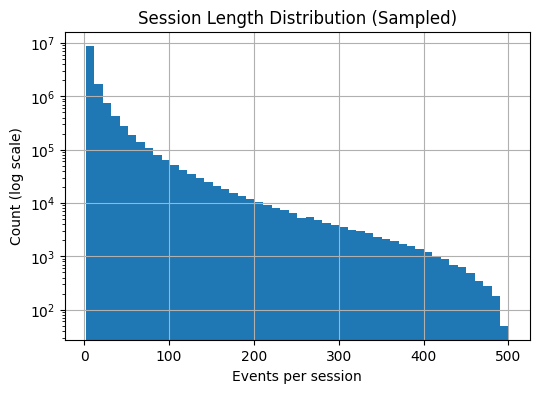

In [24]:
session_len = eda_sample.groupby("session")["aid"].size()

plt.figure(figsize=(6,4))
session_len.hist(bins=50)
plt.yscale("log")
plt.xlabel("Events per session")
plt.ylabel("Count (log scale)")
plt.title("Session Length Distribution (Sampled)")
plt.show()


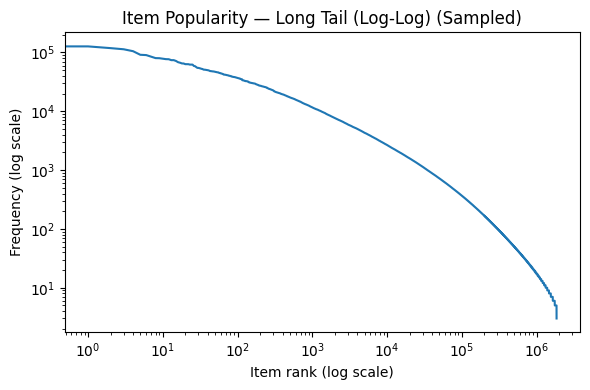

In [25]:
item_freq_sampled = eda_sample["aid"].value_counts()

plt.figure(figsize=(6,4))
plt.plot(item_freq_sampled.values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Item rank (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Item Popularity — Long Tail (Log-Log) (Sampled)")
plt.tight_layout()
plt.show()


In [26]:
rare_items_1 = (item_freq_sampled == 1).mean()
rare_items_2 = (item_freq_sampled <= 2).mean()

print(f"Items appearing only once: {rare_items_1:.2%}")
print(f"Items appearing <= 2 times: {rare_items_2:.2%}")

Items appearing only once: 0.00%
Items appearing <= 2 times: 0.00%


In [27]:
clean_memory(
    vars_to_delete=["eda_sample"],
    delete_all_dfs=True,
    verbose=True
)

Deleted variables: eda_sample, _, __, ___, _10, global_stats, _12, event_type_stats, _13, session_len_stats, _14, item_freq_stats, _15, event_timeline_cov, _16, event_volume, _17, event_type_funnel, _19, items_by_event_type, _20, zero_interactions, cooccurrence_opportunities, _23
Garbage collection complete.


# **6. Train/Validation Split & Evaluation Setup**

A chronological split is used to mirror real-world conditions where future sessions must be predicted from past behavior:

* **Train:** events before the timestamp threshold
* **Validation:** events after the threshold

For each validation session:

* **Input:** all events except the final one
* **Target:** the final item (`aid`)

Evaluation is based on standard ranking metrics:

* **Recall@K**
* **MAP@K**
* **NDCG@K**
* **Hit Rate**

---

### **Train/Validation Split Strategy**

The split is performed directly in DuckDB to avoid unnecessary memory usage.
Instead of loading the full event table into RAM, the team uses the following approach:

1. **Determine the timestamp cutoff** using the 90th percentile of session end times.
2. **Create `events_train_split` and `events_val_split`** as DuckDB tables using the cutoff.
3. **Extract only the required columns** (`session`, `aid`, `ts`, `type`) to keep tables compact.
4. **Build validation evaluation arrays (tensors)** (inputs + ground truth) in a streaming fashion.

In [28]:
# --- [DEV ONLY] Evaluation overrides ---
# EVAL_MAX_SESSIONS = 1_000    # None for full val
# EVAL_MAX_HISTORY  = 5        # last N events from each session
# TOP_K             = 20

In [29]:
# (Re)open connection explicitly
if "con" in globals():
    try:
        con.close()
    except Exception:
        pass

con = duckdb.connect(str(DUCKDB_PATH))

# Ensure base table exists (idempotent)
con.execute("DROP TABLE IF EXISTS events_train")
con.execute(f"""
    CREATE TABLE events_train AS
    SELECT
        CAST(session AS BIGINT) AS session,
        CAST(aid     AS BIGINT) AS aid,
        CAST(ts      AS BIGINT) AS ts,
        CAST(type    AS VARCHAR) AS type
    FROM read_parquet('{TRAIN_CHUNK_DIR.as_posix()}/*.parquet')
""")

# Compute per-session max timestamp
con.execute("DROP TABLE IF EXISTS session_max_ts")
con.execute("""
    CREATE TABLE session_max_ts AS
    SELECT
        session,
        MAX(ts) AS max_ts
    FROM events_train
    GROUP BY session
""")

# Compute time threshold (90th percentile of session max_ts)
ts_threshold = con.execute("""
    SELECT quantile(max_ts, 0.9) AS ts_threshold
    FROM session_max_ts
""").fetchone()[0]

print(f"Session-level timestamp threshold (90th pct of max_ts): {ts_threshold}")

# Define train/val session sets
con.execute("DROP TABLE IF EXISTS train_sessions")
con.execute("DROP TABLE IF EXISTS val_sessions")

con.execute(f"""
    CREATE TABLE train_sessions AS
    SELECT session
    FROM session_max_ts
    WHERE max_ts <= {int(ts_threshold)}
""")

con.execute(f"""
    CREATE TABLE val_sessions AS
    SELECT session
    FROM session_max_ts
    WHERE max_ts > {int(ts_threshold)}
""")

# Create train/val event tables with NO session overlap
con.execute("DROP TABLE IF EXISTS events_train_split")
con.execute("DROP TABLE IF EXISTS events_val_split")

con.execute("""
    CREATE TABLE events_train_split AS
    SELECT e.*
    FROM events_train e
    JOIN train_sessions s USING (session)
""")

con.execute("""
    CREATE TABLE events_val_split AS
    SELECT e.*
    FROM events_train e
    JOIN val_sessions s USING (session)
""")

# Inspect split sizes and time ranges
train_stats = con.execute("""
    SELECT
        COUNT(*) AS n_events,
        COUNT(DISTINCT session) AS n_sessions,
        MIN(ts) AS min_ts,
        MAX(ts) AS max_ts
    FROM events_train_split
""").df().iloc[0]

val_stats = con.execute("""
    SELECT
        COUNT(*) AS n_events,
        COUNT(DISTINCT session) AS n_sessions,
        MIN(ts) AS min_ts,
        MAX(ts) AS max_ts
    FROM events_val_split
""").df().iloc[0]

print(
    "Train split:\n"
    f"  events:   {train_stats.n_events:,}\n"
    f"  sessions: {train_stats.n_sessions:,}\n"
    f"  ts range: {train_stats.min_ts} → {train_stats.max_ts}\n"
)
print(
    "Validation split:\n"
    f"  events:   {val_stats.n_events:,}\n"
    f"  sessions: {val_stats.n_sessions:,}\n"
    f"  ts range: {val_stats.min_ts} → {val_stats.max_ts}\n"
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Session-level timestamp threshold (90th pct of max_ts): 1661667384448


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Train split:
  events:   165,885,420
  sessions: 11,609,802
  ts range: 1659304800095 → 1661667384448

Validation split:
  events:   50,830,676
  sessions: 1,289,977
  ts range: 1659304800025 → 1661723999984



In [30]:
from typing import Any, Dict

def build_eval_arrays_from_duckdb(
    con: duckdb.DuckDBPyConnection,
    src_table: str,                    # "events_val_split" or "events_test"
    min_events_per_session: int = 2,
) -> Dict[str, Any]:
    """
    Build compact evaluation arrays from a DuckDB events table.

    Returns a dict with:
        - aids:         np.ndarray[int64]   shape (n_events,)
        - event_types:  np.ndarray[int8]    shape (n_events,)
        - sess_offsets: np.ndarray[int64]   shape (n_sessions + 1,)
        - sess_ids:     np.ndarray[int64]   shape (n_sessions,)

    Sessions with < min_events_per_session events are dropped.
    Events are ordered by (session, ts).
    """
    # 1) Pull events in (session, ts) order
    query = f"""
        SELECT session, aid, type
        FROM {src_table}
        ORDER BY session, ts
    """
    df = con.execute(query).df()

    if df.empty:
        raise ValueError(f"No events found in {src_table}")

    # 2) Base arrays
    sessions = df["session"].to_numpy(dtype="int64")
    aids     = df["aid"].to_numpy(dtype="int64")
    types    = df["type"].to_numpy()  # still strings / categories

    # 3) Compute per-session lengths and drop tiny sessions
    unique_sessions, first_idx, counts = np.unique(
        sessions,
        return_index=True,
        return_counts=True,
    )

    valid_mask      = counts >= min_events_per_session
    valid_sessions  = unique_sessions[valid_mask]

    if len(valid_sessions) == 0:
        raise ValueError(
            f"No sessions with at least {min_events_per_session} events in {src_table}"
        )

    # Boolean mask over events: keep only valid sessions
    valid_session_set = set(valid_sessions.tolist())
    keep_events_mask  = np.isin(sessions, list(valid_session_set))

    sessions = sessions[keep_events_mask]
    aids     = aids[keep_events_mask]
    types    = types[keep_events_mask]

    # 4) Recompute session boundaries on the filtered arrays
    sess_ids, sess_first_idx, sess_counts = np.unique(
        sessions,
        return_index=True,
        return_counts=True,
    )

    n_sessions = len(sess_ids)
    n_events   = len(aids)

    sess_offsets = np.empty(n_sessions + 1, dtype="int64")
    sess_offsets[:-1] = sess_first_idx
    sess_offsets[-1]  = n_events

    # 5) Encode event types (string -> small integer id)
    type_ids = np.fromiter(
        (EVENT_TYPE_TO_ID[str(t)] for t in types),
        dtype=EVENT_TYPE_DTYPE,
        count=n_events,
    )

    print(
        f"[build_eval_arrays_from_duckdb] {src_table}: "
        f"{n_sessions:,} sessions, {n_events:,} events "
        f"(min_events_per_session={min_events_per_session})"
    )

    return {
        "aids": aids,
        "event_types": type_ids,
        "sess_offsets": sess_offsets,
        "sess_ids": sess_ids,
    }


In [31]:
# Build compact eval arrays (one-time per run)
val_arrays = build_eval_arrays_from_duckdb(
    con,
    src_table="events_val_split",
    min_events_per_session=2,
)

test_arrays = build_eval_arrays_from_duckdb(
    con,
    src_table="events_test",
    min_events_per_session=2,
)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[build_eval_arrays_from_duckdb] events_val_split: 1,289,977 sessions, 50,830,676 events (min_events_per_session=2)
[build_eval_arrays_from_duckdb] events_test: 1,671,803 sessions, 13,851,293 events (min_events_per_session=2)


In [32]:
import math

def metrics_for_one(
    y_true: int,
    y_pred: List[int],
    k: int,
):
    """
    Compute single-session metrics in one pass:
      - hit  (Recall@K for single target)
      - ndcg
      - ap   (AP@K for single positive)
      - mrr
    """
    topk = y_pred[:k]
    hit = 0.0
    ndcg = 0.0
    ap = 0.0
    mrr = 0.0

    # TODO: document metrics
    for idx, item in enumerate(topk):
        if item == y_true:
            rank = idx + 1  # 1-based
            hit  = 1.0
            ndcg = 1.0 / math.log2(rank + 1)
            ap   = 1.0 / rank
            mrr  = 1.0 / rank
            break

    return hit, ndcg, ap, mrr


def evaluate_recommender(
    arrays: Dict[str, Any],
    recommend_fn,
    k: int = TOP_K,
    max_history: Optional[int] = EVAL_MAX_HISTORY,
    max_sessions: Optional[int] = EVAL_MAX_SESSIONS,
) -> Dict[str, float]:
    """
    Evaluation using compact arrays (no DuckDB / DataFrame in the hot loop).

    arrays must contain:
        - aids: np.ndarray[int64]
        - event_types: np.ndarray[int8]
        - sess_offsets: np.ndarray[int64]
        - sess_ids: np.ndarray[int64]
    """

    aids         = arrays["aids"]
    event_types  = arrays["event_types"]
    sess_offsets = arrays["sess_offsets"]
    # sess_ids   = arrays["sess_ids"]  # unused for metrics

    n_sessions_total = len(sess_offsets) - 1
    n_sessions_eval = (
        min(n_sessions_total, max_sessions)
        if max_sessions is not None
        else n_sessions_total
    )

    if n_sessions_eval <= 0:
        return {
            f"recall@{k}": 0.0,
            f"ndcg@{k}":   0.0,
            f"map@{k}":    0.0,
            f"mrr@{k}":    0.0,
            "hit_rate":    0.0,
            "n_sessions":  0,
        }

    recalls: List[float] = []
    ndcgs:   List[float] = []
    aps:     List[float] = []
    mrrs:    List[float] = []

    for i in range(n_sessions_eval):
        start = sess_offsets[i]
        end   = sess_offsets[i + 1]

        # Safety check (shouldn't happen if min_events_per_session>=2)
        if end - start < 2:
            continue

        target_aid = int(aids[end - 1])

        hist_aids   = aids[start:end - 1]
        hist_types_ids = event_types[start:end - 1]

        if max_history is not None:
            hist_aids       = hist_aids[-max_history:]
            hist_types_ids  = hist_types_ids[-max_history:]

        input_aids = hist_aids.tolist()
        # Convert type IDs back to strings so existing recommenders work unchanged
        input_types = [EVENT_ID_TO_TYPE[int(t)] for t in hist_types_ids]

        recs = recommend_fn(input_aids, input_types)

        hit, nd, ap, mrr = metrics_for_one(target_aid, recs, k)

        recalls.append(hit)
        ndcgs.append(nd)
        aps.append(ap)
        mrrs.append(mrr)

    recalls_arr = np.asarray(recalls, dtype="float32")
    ndcgs_arr   = np.asarray(ndcgs,   dtype="float32")
    aps_arr     = np.asarray(aps,     dtype="float32")
    mrrs_arr    = np.asarray(mrrs,    dtype="float32")

    return {
        f"recall@{k}": float(recalls_arr.mean()),
        f"ndcg@{k}":   float(ndcgs_arr.mean()),
        f"map@{k}":    float(aps_arr.mean()),
        f"mrr@{k}":    float(mrrs_arr.mean()),
        "hit_rate":    float((recalls_arr > 0).mean()),
        "n_sessions":  int(len(recalls_arr)),
    }



### Top-Seller Recommendation Model (Recency-Weighted Popularity)

This model implements the **Top-Seller** requirement by identifying globally popular
items from the training data using **event-type weights** and **exponential recency
decay**. The solution is fully **DuckDB-backed**, allowing scalable computation
directly over parquet data without loading the full dataset into memory.

#### Methodology

1. **Event Weighting**
   Each interaction type contributes differently to popularity:
   - clicks → 1.0
   - carts  → 3.0
   - orders → 5.0

   These weights reflect increasing strength of user intent.

2. **Recency-Aware Scoring**
   For each event, a time decay factor is applied:
   \[
   w = \text{event\_weight} \times e^{-\lambda \cdot \text{age\_in\_days}}
   \]
   where `λ = RECENCY_DECAY_LAMBDA`.
   Recent events contribute more, helping the ranking adapt to trends.

3. **Aggregation in DuckDB**
   DuckDB computes:
   - the global maximum timestamp,
   - weighted + decayed popularity contributions per event,
   - total popularity per `aid`.

   The result is a sorted popularity table:
   ```text
   aid → recency-weighted popularity score


4. **Serving Top-Seller Recommendations**
   For inference, the recommender simply returns the top-K globally ranked items:

   ```python
   TOP_SELLERS[:k]
   ```

#### Stored Artifacts for Inference

* `top_seller_popularity.parquet` (aid, score)
* `TOP_SELLERS` list or equivalent
* `metadata.json` describing:

  * data version
  * DuckDB table version
  * event weights
  * recency decay lambda
  * model version and metrics


In [33]:
# --- [DEV ONLY] Top-seller overrides ---
# RECENCY_DECAY_LAMBDA = 0.01
# MAX_POPULARITY_ITEMS = 10_000
# EVENT_WEIGHTS = { "clicks": 1.0, "carts":  3.0, "orders": 5.0 }

In [34]:
# Popularity computation
def compute_recency_weighted_popularity(
    con: duckdb.DuckDBPyConnection,
    src_table: str = "events_train_split",
    target_table: str = "popular_items",
    decay_lambda: float = RECENCY_DECAY_LAMBDA,
    top_n: int = MAX_POPULARITY_ITEMS,
):
    """
    Compute recency-weighted popularity and store the top-N results
    directly as a DuckDB table. No pandas objects are created.
    """
    con.execute(f"DROP TABLE IF EXISTS {target_table}")

    query = f"""
        CREATE TABLE {target_table} AS
        WITH params AS (
            SELECT MAX(ts) AS max_ts FROM {src_table}
        ),
        scored AS (
            SELECT
                e.aid,
                (
                    CASE
                        WHEN e.type = 'clicks' THEN {EVENT_WEIGHTS["clicks"]}
                        WHEN e.type = 'carts'  THEN {EVENT_WEIGHTS["carts"]}
                        WHEN e.type = 'orders' THEN {EVENT_WEIGHTS["orders"]}
                        ELSE 0.0
                    END
                ) *
                EXP(
                    -({float(decay_lambda)}) *
                    ((p.max_ts - e.ts) / (1000.0 * 60 * 60 * 24))
                ) AS pop_weight
            FROM {src_table} e
            CROSS JOIN params p
        )
        SELECT aid, SUM(pop_weight) AS score
        FROM scored
        GROUP BY aid
        ORDER BY score DESC
        LIMIT {int(top_n)};
    """

    con.execute(query)

    count = con.execute(f"SELECT COUNT(*) FROM {target_table}").fetchone()[0]
    print(f"Created DuckDB table `{target_table}` with {count:,} top items.")


compute_recency_weighted_popularity(
    con,
    src_table="events_train_split",
    target_table="popular_items",
    decay_lambda=RECENCY_DECAY_LAMBDA,
    top_n=MAX_POPULARITY_ITEMS,
)


Created DuckDB table `popular_items` with 10,000 top items.


In [35]:
# Top-Seller baseline recommender and evaluation
TOP_SELLERS = [
    row[0] for row in con.execute(F"""
        SELECT aid
        FROM popular_items
        ORDER BY score DESC
        LIMIT {MAX_POPULARITY_ITEMS}
    """).fetchall()
]

def recommend_top_sellers(input_aids, input_types, k: int = TOP_K) -> List[int]:
    return TOP_SELLERS[:k]

In [36]:
con.execute("DROP TABLE IF EXISTS covis_neighbors")

query = f"""
    WITH source AS (
        SELECT
            e.session,
            e.aid,
            e.ts,
            e.type,
            ROW_NUMBER() OVER (
                PARTITION BY e.session
                ORDER BY e.ts DESC
            ) AS rn
        FROM events_train_split AS e
        JOIN popular_items AS p
              ON e.aid = p.aid
        WHERE e.type IN ('clicks', 'carts', 'orders')
    ),

    limited AS (
        SELECT *
        FROM source
        WHERE rn <= {COVIS_SESSION_LIMIT}
    ),

    pairs AS (
        SELECT
            a.aid AS aid_x,
            b.aid AS aid_y,

            -- ============================
            -- Weighted signal + time decay
            -- ============================
            SUM(
                (
                    CASE
                        WHEN b.type = 'clicks' THEN {EVENT_WEIGHTS['clicks']}
                        WHEN b.type = 'carts'  THEN {EVENT_WEIGHTS['carts']}
                        WHEN b.type = 'orders' THEN {EVENT_WEIGHTS['orders']}
                        ELSE 0.0
                    END
                )
                *
                EXP(
                    -{COVIS_TIME_DECAY_LAMBDA} *
                    ((CAST(b.ts AS DOUBLE) - CAST(a.ts AS DOUBLE))
                     / (1000.0 * 60 * 60))    -- convert ms → hours
                )
            ) AS wgt

        FROM limited a
        JOIN limited b
              ON a.session = b.session
             AND a.aid != b.aid
             AND b.ts > a.ts                           -- canonical ordering
             AND (b.ts - a.ts) <= {COVIS_MAX_TIME_MS} -- time window
        GROUP BY a.aid, b.aid
    ),

    ranked AS (
        SELECT
            aid_x,
            aid_y,
            wgt,
            ROW_NUMBER() OVER (
                PARTITION BY aid_x
                ORDER BY wgt DESC
            ) AS rn
        FROM pairs
    )

    SELECT aid_x, aid_y, wgt
    FROM ranked
    WHERE rn <= {COVIS_TOPK}
"""

con.execute(f"CREATE TABLE covis_neighbors AS {query}")

print("Co-vis table created:")
display(con.execute("SELECT COUNT(*) AS n_rows FROM covis_neighbors").df())
display(con.execute("SELECT * FROM covis_neighbors LIMIT 10").df())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Co-vis table created:


,n_rows
0,400000


,aid_x,aid_y,wgt
0,1763383,479985,2048.779038
1,1763383,1620020,1757.265801
2,1763383,879201,1718.563347
3,1763383,981427,1532.192215
4,1763383,661838,1225.885434
5,1763383,1617771,1009.786013
6,1763383,793452,916.205859
7,1763383,597707,630.448021
8,1763383,501077,627.506789
9,1763383,6517,365.454351


In [37]:
baseline_metrics = evaluate_recommender(
    val_arrays,
    recommend_top_sellers,
    k=TOP_K,
    max_sessions=EVAL_MAX_SESSIONS,   # or None for full eval
    max_history=EVAL_MAX_HISTORY,        # optional: only last x events as context
)
baseline_metrics

{'recall@20': 0.008752093650400639,
 'ndcg@20': 0.0029575396329164505,
 'map@20': 0.0013908734545111656,
 'mrr@20': 0.0013908734545111656,
 'hit_rate': 0.008752094029583473,
 'n_sessions': 1289977}

In [38]:
# Artifacts and manifest
# Example: popularity artifacts
popular_items_df = con.execute("""
    SELECT aid, score
    FROM popular_items
    ORDER BY score DESC
""").df()

popular_items_path = Path(RUN_MANIFEST.artifact_repo) / "popular_items.parquet"
popular_items_df.to_parquet(popular_items_path, index=False)

RUN_MANIFEST.add_artifact(
    name="popular_items",
    path=popular_items_path,
    kind="parquet",
    description="Recency-weighted item popularity (top N)",
)

RUN_MANIFEST.add_metric("validation", "popularity_baseline", baseline_metrics)
RUN_MANIFEST.save()

[Manifest] Saved to ../models/1.0__f6843aa7/manifest.json


## Co-Visitation Matrix

We use a **co-visitation matrix** to estimate item-to-item similarity based on
how products appear together inside user sessions. This is a lightweight and
fast way to generate real-time recommendations without heavy ML models.

### What we do:
- Use weighted signals between (`clicks`, `carts`, `orders`) when building co-vis pairs. Weights being more in favor of stronger signals (`orders` > `carts` > `clicks`).
- Keep the **last N events per session** to avoid long-session explosion.
- Only pair events that happen within a **12-hour window**.
- Apply **event-type weights** (orders > carts).
- Apply optional **time decay** inside the window.
- Keep only **Top-K neighbors** per item for fast lookups.

**Note**: we restrict co-visitation to items present in the popular_items table.
This trades some long-tail coverage for faster computation and a smaller,
more stable similarity index focused on high-traffic items.

---

### Co-Vis Config (Build Phase)

| Variable | Meaning | Typical Values |
|---------|---------|----------------|
| `COVIS_SESSION_LIMIT` | How many recent events per session to use when building co-vis pairs | 20 (dev: 5–10) |
| `COVIS_TOPK` | Number of top neighbors per item to keep in the final table | 40 (dev: 10–20) |
| `COVIS_MAX_TIME_MS` | Max allowed time gap between events when pairing | 12 hours |
| `COVIS_TIME_DECAY_LAMBDA` | Strength of time decay inside the window | 0.05 (lower = weaker decay) |

---

### Artifacts Produced (Needed for Inference)

The co-visitation build step produces:

- **`covis_neighbors` DuckDB table**
- **`covis_neighbors_index.pkl`** — a Python dict
  `{aid_x: [(aid_y, score), ...]}`

The `.pkl` artifact is loaded once at API startup and used during real-time
recommendation for ultra-fast lookups.

In [39]:
# --- [DEV ONLY] Co-vis build overrides ---
# COVIS_SESSION_LIMIT     = 20
# COVIS_TOPK              = 40
# COVIS_MAX_TIME_MS       = 12 * 60 * 60 * 1000
# COVIS_TIME_DECAY_LAMBDA = 0.05
# W_CLICK = 0.0
# W_CART  = 3.0
# W_ORDER = 5.0

In [40]:
def build_neighbors_index(
    df: pd.DataFrame,
) -> Dict[int, List[Tuple[int, float]]]:
    """
    Build neighbors_index from a DuckDB co-vis table.
    Assumes df has columns: [aid_x, aid_y, wgt]
    and is already truncated to top-K per aid_x in DuckDB.
    """
    neighbors_index = (
        df
        .groupby("aid_x")[["aid_y", "wgt"]]
        .apply(lambda g: list(zip(g["aid_y"].tolist(), g["wgt"].tolist())))
        .to_dict()
    )
    return neighbors_index

In [41]:
# Artifact

neighbors_index = build_neighbors_index(con.execute("SELECT * FROM covis_neighbors").df())

covis_index_path = Path(RUN_MANIFEST.artifact_repo) / "covis_neighbors_index.pkl"
with covis_index_path.open("wb") as f:
    pickle.dump(neighbors_index, f)

RUN_MANIFEST.add_artifact(
    name="covis_neighbors_index",
    path=covis_index_path,
    kind="pickle",
    description="Session-based co-visitation neighbors per item",
)
RUN_MANIFEST.save()

[Manifest] Saved to ../models/1.0__f6843aa7/manifest.json


**NOTES**

## Co-Visitation Recommender

The recommender uses the precomputed co-vis matrix and the user’s recent session
history to produce a ranked list of items.

### What the recommender does:
- Looks at the **last few interacted items** in the session.
- Applies **recency weighting** → more recent actions matter more.
- Applies **event-type weighting** → carts/orders influence more than clicks.
- Collects neighbors for each source item and **aggregates their scores**.
- Filters out items already seen in the session.
- Backfills with **Top-Sellers** if there aren't enough candidates.

This gives a fast, practical real-time recommender similar to production
systems used in e-commerce.

---

### Co-Vis Config (Recommender Phase)

| Variable | Meaning | Typical Values |
|---------|---------|----------------|
| `COVIS_MAX_HISTORY` | How many of the user’s most recent session events we use | 10–20 |
| `COVIS_RECENCY_BASE` | Strength of recency decay (0.9 means 10% drop for each step back) | 0.9 |
| `COVIS_SOURCE_TYPE_WEIGHTS` | Weight per event type (click/cart/order) | `{click:1, cart:1.5, order:2}` |
| `TOP_K` | Number of items returned by the recommender | 20 |

---

### Required Artifacts for Inference

At recommendation time, the following artifacts must be loaded:

- **`neighbors_index`** (from `covis_neighbors_index.pkl`)
  → used for O(1) item-to-item similarity lookup
- **`popular_items`** table or its serialized top-K list
  → used as a fallback / backfill
- (Optional) **event-type weights / config**
  → if the inference logic applies recency or type weighting

All of these are lightweight, in-memory structures that allow sub-millisecond
real-time scoring.

In [42]:
# --- [DEV ONLY] Co-vis inference overrides ---
# COVIS_MAX_HISTORY  = 10
# COVIS_RECENCY_BASE = 0.9
# COVIS_SOURCE_TYPE_WEIGHTS = { "clicks": 1.0, "carts":  1.5, "orders": 2.0 }

In [43]:
def recommend_covis(
    session_aids: List[int],
    session_types: List[str],
    k: int = TOP_K,
    max_history: int = COVIS_MAX_HISTORY,
) -> List[int]:
    """
    Co-visitation recommender (improved):

    - Uses the last `max_history` items (not just the last one).
    - Applies recency weighting: more recent source items matter more.
    - Applies type weighting: carts/orders contribute more than clicks.
    - Aggregates neighbor scores across all source items.
    - Filters out items already seen in the session.
    - Backfills with global popularity if needed.

    session_aids: list[int]   # ordered in time
    session_types: list[str]  # same length as session_aids
    k: int                    # number of recommendations
    """

    # No session context → fallback to global top-sellers
    if not session_aids:
        return recommend_top_sellers([], [], k=k)

    # Take last N events as context
    hist_aids = session_aids[-max_history:]
    hist_types = session_types[-max_history:]

    # We’ll work from most recent backwards.
    zipped = list(zip(hist_aids, hist_types))
    # reverse to handle recency weighting in natural order (most recent first)
    zipped_rev = list(reversed(zipped))

    candidate_scores: Dict[int, float] = {}
    seen_in_session = set(session_aids)

    for idx, (aid_x, type_x) in enumerate(zipped_rev):
        # Recency weight: most recent gets weight 1.0, then 0.9, 0.9^2, ...
        recency_w = COVIS_RECENCY_BASE ** idx

        # Type weight: carts/orders > clicks
        type_w = EVENT_WEIGHTS.get(type_x, 1.0)

        source_weight = recency_w * type_w

        neighbors = neighbors_index.get(aid_x)
        if not neighbors:
            continue

        for aid_y, wgt in neighbors:
            # Do not recommend items already seen in the session
            if aid_y in seen_in_session:
                continue

            # Aggregate score: co-vis weight * source (recency * type)
            candidate_scores[aid_y] = candidate_scores.get(aid_y, 0.0) + wgt * source_weight

    # If we somehow got no candidates → pure popularity fallback
    if not candidate_scores:
        return recommend_top_sellers([], [], k=k)

    # Sort by aggregated score
    ranked = sorted(candidate_scores.items(), key=lambda x: x[1], reverse=True)
    recs = [aid for aid, _ in ranked[:k]]

    # Backfill with popularity if fewer than k candidates
    if len(recs) < k:
        needed = k - len(recs)
        # get more popular items (taking >k to be safe)
        pop_candidates = recommend_top_sellers([], [], k=k * 2)
        for aid in pop_candidates:
            if aid in seen_in_session or aid in recs:
                continue
            recs.append(aid)
            if len(recs) >= k:
                break

    return recs[:k]

In [44]:
covis_metrics = evaluate_recommender(
    val_arrays,
    recommend_covis,
    k=TOP_K,
    max_sessions=EVAL_MAX_SESSIONS,    # None for all validation sessions
    max_history=EVAL_MAX_HISTORY,   # this controls how much of val session you feed in;
)

# Manifest
RUN_MANIFEST.add_metric("validation", "covis", covis_metrics)
RUN_MANIFEST.save()

covis_metrics

[Manifest] Saved to ../models/1.0__f6843aa7/manifest.json


{'recall@20': 0.04265114665031433,
 'ndcg@20': 0.020996587350964546,
 'map@20': 0.014848272316157818,
 'mrr@20': 0.014848272316157818,
 'hit_rate': 0.04265114804372481,
 'n_sessions': 1289977}

In [45]:
clean_memory(['candidate_scores', 'ranked'], delete_all_dfs=True, verbose=True)

Deleted variables: ___, popular_items_df
Garbage collection complete.


## Item2Vec-Lite (Embedding-Based Item Similarity)

Item2Vec provides a lightweight, behavior-driven embedding of items by treating
each session as a “sentence” and each `aid` as a “token”.
This complements the co-visitation matrices by capturing **semantic similarity**
between items—even when direct co-occurrence is sparse or noisy.

We train Item2Vec directly on `events_train_split` using a **streaming pipeline**
from DuckDB, allowing us to scale to millions of sessions while keeping memory
usage low.

The learned embeddings provide a dense vector representation for each item,
which we later index using **FAISS** for fast, scalable nearest-neighbor searches
during real-time recommendations.

---

### Configuration

All operational hyperparameters live in the **global config cell** for reuse across
training, evaluation, and inference.
During notebook experimentation, we allow local overrides where needed.

| Variable                | Meaning                                   |
|------------------------|---------------------------------------------|
| `ITEM2VEC_EMBED_DIM`  | Embedding dimensionality                    |
| `ITEM2VEC_WINDOW`     | Context window size (session positions)     |
| `ITEM2VEC_MIN_COUNT`  | Minimum item frequency to include           |
| `ITEM2VEC_NEGATIVE`   | Negative samples per positive               |
| `ITEM2VEC_EPOCHS`     | Number of streamed training epochs          |
| `ITEM2VEC_BATCH_SIZE` | Sessions per DuckDB batch during training   |

These settings intentionally keep the model small, fast, and suitable for
production-oriented real-time applications.

---

### Development vs Full Training

Training Item2Vec on the full OTTO dataset is computationally intensive.
To keep the notebook responsive during prototyping, we allow a development-only
cap on the number of sessions:

- **`MAX_SESSIONS_FOR_W2V`** — optional limit for training.

Behavior:

- When set (e.g., `300_000`), we restrict the SQL query with `LIMIT N`.
- When `None`, we train on **all** sessions in `events_train_split`.

Session selection:

```sql
SELECT DISTINCT session
FROM events_train_split
ORDER BY session
[LIMIT N]   -- present only when MAX_SESSIONS_FOR_W2V is set
```


In [46]:
# --- [DEV ONLY] Item2Vec training overrides ---
# ITEM2VEC_EMBED_DIM   = 32
# ITEM2VEC_WINDOW      = 3
# ITEM2VEC_MIN_COUNT   = 5
# ITEM2VEC_NEGATIVE    = 3
# ITEM2VEC_EPOCHS      = 1
# ITEM2VEC_BATCH_SIZE  = 100_000
# MAX_SESSIONS_FOR_W2V = 300_000  # or None for full data

In [47]:
session_query = """
    SELECT DISTINCT session
    FROM events_train_split
    ORDER BY session
"""

if MAX_SESSIONS_FOR_W2V is not None:
    session_query += f" LIMIT {MAX_SESSIONS_FOR_W2V}"

session_ids = con.execute(session_query).df()["session"].tolist()

len(session_ids)

11609802

In [48]:
def stream_session_sequences_batches(
    con,
    session_ids,
    batch_size=ITEM2VEC_BATCH_SIZE,
):
    """
    Yield batches of session sequences (lists of aids) from DuckDB.

    Returns: list[list[int]] per batch.
    """
    for i in range(0, len(session_ids), batch_size):
        batch = session_ids[i: i + batch_size]
        df = con.execute(f"""
            SELECT session, LIST(aid ORDER BY ts) AS aids
            FROM events_train_split
            WHERE session IN ({','.join(map(str, batch))})
            GROUP BY session
        """).df()
        yield df["aids"].tolist()


def iter_w2v_sentences(
    con,
    session_ids,
    batch_size=ITEM2VEC_BATCH_SIZE,
):
    """
    Generator that yields sentences for Word2Vec:

        ["aid1", "aid2", "aid3", ...]

    Each sentence corresponds to one session's ordered item sequence.
    This generator can be re-created for each pass (vocab / training).
    """
    for seqs in stream_session_sequences_batches(con, session_ids, batch_size=batch_size):
        for s in seqs:
            # Convert item ids to strings for Word2Vec tokens
            yield [str(a) for a in s]



In [49]:
# Create the model (config from global / local Item2Vec config)
w2v_model = Word2Vec(
    vector_size=ITEM2VEC_EMBED_DIM,
    window=ITEM2VEC_WINDOW,
    min_count=ITEM2VEC_MIN_COUNT,
    negative=ITEM2VEC_NEGATIVE,
    sg=1,          # skip-gram
    workers=4,     # or ITEM2VEC_WORKERS
)

# Number of "sentences" (one per session)
n_sentences = len(session_ids)

# ---- 1) Build vocabulary: single streaming pass ----
print("Building Word2Vec vocabulary (streamed)...")
w2v_model.build_vocab(
    iter_w2v_sentences(con, session_ids, batch_size=ITEM2VEC_BATCH_SIZE),
    progress_per=50_000,
)
print(f"Vocab size: {len(w2v_model.wv)} tokens, vector dim = {w2v_model.vector_size}")

# ---- 2) Train in streaming epochs ----
for epoch in range(ITEM2VEC_EPOCHS):
    print(f"Training epoch {epoch+1}/{ITEM2VEC_EPOCHS}...")
    w2v_model.train(
        iter_w2v_sentences(con, session_ids, batch_size=ITEM2VEC_BATCH_SIZE),
        total_examples=n_sentences,
        epochs=1,
    )


Building Word2Vec vocabulary (streamed)...
Vocab size: 1687884 tokens, vector dim = 32
Training epoch 1/3...
Training epoch 2/3...
Training epoch 3/3...


In [50]:
# -------------------------
# Word2Vec vocabulary + vectors
# -------------------------
w2v_items = np.array(w2v_model.wv.index_to_key)   # strings
item_vectors = w2v_model.wv.vectors               # float32, shape: (n_items, dim)

# Float32 + contiguous
item_vectors_f = np.ascontiguousarray(item_vectors.astype("float32"))
dim = item_vectors_f.shape[1]

# Normalize for cosine similarity
faiss.normalize_L2(item_vectors_f)

# -------------------------
# Build FAISS ANN index (HNSW)
# -------------------------
index = faiss.IndexHNSWFlat(dim, 32)   # M = 32 neighbors per node
index.hnsw.efConstruction = 200        # build-time accuracy/speed tradeoff
index.hnsw.efSearch = 64               # query-time accuracy/speed tradeoff

index.add(item_vectors_f)

print("FAISS HNSW index built with", index.ntotal, "items, dim=", dim)

# -------------------------
# FAST INTEGER LOOKUP TABLE (critical for speed)
# -------------------------
w2v_items_int = np.array([int(x) for x in w2v_items], dtype=np.int64)

max_aid = int(w2v_items_int.max())
item2vec_row_for_aid = np.full(max_aid + 1, -1, dtype=np.int32)
item2vec_row_for_aid[w2v_items_int] = np.arange(len(w2v_items_int), dtype=np.int32)

print("Item2Vec vocab size:", len(w2v_items_int))
print("Max aid:", max_aid)

# Optional: legacy map
w2v_item_to_idx = {int(item): i for i, item in enumerate(w2v_items)}

FAISS HNSW index built with 1687884 items, dim= 32
Item2Vec vocab size: 1687884
Max aid: 1855602


In [51]:
# persist Item2Vec artifacts under the run-specific artifact repo
ITEM2VEC_DIR = Path(RUN_MANIFEST.artifact_repo) / "item2vec"
ITEM2VEC_DIR.mkdir(parents=True, exist_ok=True)

# Save gensim model
w2v_model.save(str(ITEM2VEC_DIR / "item2vec_w2v.model"))

# Save vectors + vocab
np.save(ITEM2VEC_DIR / "item_vectors.npy", item_vectors)
with open(ITEM2VEC_DIR / "w2v_items.txt", "w") as f:
    for item in w2v_items:
        f.write(item + "\n")

# Save additional FAISS index
faiss.write_index(index, str(ITEM2VEC_DIR / "faiss_index.bin"))

RUN_MANIFEST.add_artifact(
    name="item2vec_model",
    path=ITEM2VEC_DIR / "item2vec_w2v.model",
    kind="gensim_word2vec",
    description="Item2Vec Word2Vec model",
)

RUN_MANIFEST.add_artifact(
    name="item2vec_vectors",
    path=ITEM2VEC_DIR / "item_vectors.npy",
    kind="npy",
    description="Item2Vec embedding matrix aligned with w2v_items.txt",
)

RUN_MANIFEST.add_artifact(
    name="item2vec_items",
    path=ITEM2VEC_DIR / "w2v_items.txt",
    kind="txt",
    description="Item index → aid mapping for Item2Vec vectors",
)

RUN_MANIFEST.add_artifact(
    name="faiss_index",
    path=ITEM2VEC_DIR / "faiss_index.bin",
    kind="faiss_index",
    description="FAISS Inner-Product index (normalized vectors)",
    metadata={"dim": dim, "ntotal": index.ntotal}
)

RUN_MANIFEST.save()

[Manifest] Saved to ../models/1.0__f6843aa7/manifest.json


A simple way to load at inference

```python
import numpy as np
import faiss

ITEM2VEC_DIR = PROC_DIR / "item2vec"

# Load vector matrix & item IDs
item_vectors = np.load(ITEM2VEC_DIR / "item_vectors.npy")

with open(ITEM2VEC_DIR / "w2v_items.txt") as f:
    w2v_items = np.array([line.strip() for line in f])

# Build index → vocab mapping
w2v_item_to_idx = {item: i for i, item in enumerate(w2v_items)}

# Convert to float32 + contiguous
item_vectors_f = np.ascontiguousarray(item_vectors.astype("float32"))

# Normalize L2 for cosine similarity via inner-product
faiss.normalize_L2(item_vectors_f)

dim = item_vectors_f.shape[1]

# Build exact cosine-similarity index
faiss_index = faiss.IndexFlatIP(dim)
faiss_index.add(item_vectors_f)

print("FAISS index built.")
print(f"Item vectors: {item_vectors_f.shape}, index size: {faiss_index.ntotal}")
```

In [52]:
# --- [DEV ONLY] Item2Vec inference overrides ---
# CONTEXT_LEN = 5

In [53]:
# Inference-time recommender using Item2Vec + FAISS

def recommend_item2vec(
    session_aids,
    session_types,   # kept for compatibility; not used
    k: int = TOP_K,
) -> list[int]:
    """
    Item2Vec+FAISS recommender with a tighter inner loop:

    - Vectorized mapping from aids -> embedding indices via item2vec_row_for_aid.
    - Minimal Python overhead per call.
    - Same logic: last CONTEXT_LEN items, average embedding, cosine similarity,
      filter seen items, popularity backfill.
    """

    if not session_aids:
        return recommend_top_sellers([], [], k=k)

    # Last N items as context
    context_np = np.asarray(session_aids[-CONTEXT_LEN:], dtype=np.int64)

    # Map aids -> row indices (vectorized)
    idxs = item2vec_row_for_aid[context_np]
    idxs = idxs[idxs >= 0]   # drop items not in vocab

    if idxs.size == 0:
        return recommend_top_sellers([], [], k=k)

    # Average pre-normalized vectors to get query
    context_vec = item_vectors_f[idxs].mean(axis=0, keepdims=True).astype("float32")
    faiss.normalize_L2(context_vec)

    seen = set(session_aids)

    # Ask FAISS for some extra to compensate for filtering
    n_query = min(k + len(seen) + 10, index.ntotal)  # +10 safety margin

    scores, faiss_indices = index.search(context_vec, n_query)
    candidate_aids = w2v_items_int[faiss_indices[0]]

    recs = []
    for aid in candidate_aids:
        if aid in seen:
            continue
        recs.append(int(aid))
        if len(recs) >= k:
            break

    # Backfill with top sellers if needed
    if len(recs) < k:
        for ts in recommend_top_sellers([], [], k=k * 2):
            if ts in seen:
                continue
            if ts in recs:
                continue
            recs.append(ts)
            if len(recs) >= k:
                break

    return recs[:k]



In [54]:
# dear god
def evaluate_item2vec_batched(
    arrays,
    k: int,
    max_sessions: int | None = None,
    max_history: int | None = None,
    context_len: int | None = None,
    batch_size: int = 4096,
    faiss_extra: int = 50,
):
    """
    Full batched evaluation for Item2Vec+FAISS.

    - Precomputes a query embedding per session.
    - Runs FAISS search in batches.
    - Reconstructs per-session rec lists (with seen-item filtering + popularity backfill).
    - Returns a metrics dict with the same structure as evaluate_recommender:
        {
          f"recall@{k}",
          f"ndcg@{k}",
          f"map@{k}",
          "mrr",
          "hit_rate",
          "n_sessions",
        }
    """

    aids         = arrays["aids"]
    sess_offsets = arrays["sess_offsets"]

    n_sessions_total = len(sess_offsets) - 1
    n_sessions_eval = (
        min(n_sessions_total, max_sessions)
        if max_sessions is not None
        else n_sessions_total
    )

    query_vecs = []
    targets = []
    sess_ids = []

    # Build query embeddings (one per session)
    for i in range(n_sessions_eval):
        start = sess_offsets[i]
        end   = sess_offsets[i + 1]

        # need at least 2 events: history + target
        if end - start < 2:
            continue

        target_aid = int(aids[end - 1])
        hist_aids  = aids[start:end - 1]

        if max_history is not None:
            hist_aids = hist_aids[-max_history:]

        if len(hist_aids) == 0:
            continue

        # last context_len events
        if context_len is not None:
            hist_aids = hist_aids[-context_len:]

        hist_np = np.asarray(hist_aids, dtype=np.int64)

        # map aids -> item2vec rows
        idxs = item2vec_row_for_aid[hist_np]
        idxs = idxs[idxs >= 0]   # drop out-of-vocab

        if idxs.size == 0:
            continue

        # average normalized embeddings → query vector
        vec = item_vectors_f[idxs].mean(axis=0)

        query_vecs.append(vec)
        targets.append(target_aid)
        sess_ids.append(i)

    if not query_vecs:
        raise ValueError("No valid sessions for Item2Vec evaluation.")

    Q = np.stack(query_vecs, axis=0).astype("float32")
    faiss.normalize_L2(Q)

    targets = np.asarray(targets, dtype=np.int64)
    sess_ids = np.asarray(sess_ids, dtype=np.int64)

    # Batched FAISS search
    recalls = []
    ndcgs   = []
    aps     = []
    mrrs    = []

    n_queries = Q.shape[0]
    n_extra = faiss_extra  # cushion for filtering seen items

    for start_q in range(0, n_queries, batch_size):
        end_q = min(start_q + batch_size, n_queries)
        Q_batch = Q[start_q:end_q]

        # One FAISS call for a whole batch
        scores, neigh_idx = index.search(Q_batch, k + n_extra)
        # Map FAISS indices → integer item ids
        candidates_batch = w2v_items_int[neigh_idx]  # shape: [batch, k+n_extra]

        # Per-session post-processing + metrics
        for row in range(Q_batch.shape[0]):
            global_row = start_q + row
            sess_idx   = sess_ids[global_row]
            target     = targets[global_row]

            s_start = sess_offsets[sess_idx]
            s_end   = sess_offsets[sess_idx + 1]
            hist_aids = aids[s_start:s_end - 1]

            if max_history is not None:
                hist_aids = hist_aids[-max_history:]

            seen = set(int(a) for a in hist_aids.tolist())

            candidate_aids = candidates_batch[row]

            # Build recs: filter seen, cap at k
            recs = []
            for aid in candidate_aids:
                aid_int = int(aid)
                if aid_int in seen:
                    continue
                recs.append(aid_int)
                if len(recs) >= k:
                    break

            # Popularity backfill (same behavior as recommend_item2vec)
            if len(recs) < k:
                for ts in recommend_top_sellers([], [], k=k * 2):
                    if ts in seen or ts in recs:
                        continue
                    recs.append(ts)
                    if len(recs) >= k:
                        break

            recs_k = recs[:k]

            # ---- metrics ----
            if target in recs_k:
                hit = 1.0
                rank = recs_k.index(target)
                ndcg = 1.0 / np.log2(rank + 2.0)
                ap   = 1.0          # single relevant item
                mrr  = 1.0 / (rank + 1.0)
            else:
                hit  = 0.0
                ndcg = 0.0
                ap   = 0.0
                mrr  = 0.0

            recalls.append(hit)
            ndcgs.append(ndcg)
            aps.append(ap)
            mrrs.append(mrr)

    recalls = np.asarray(recalls, dtype=np.float32)
    ndcgs   = np.asarray(ndcgs,   dtype=np.float32)
    aps     = np.asarray(aps,     dtype=np.float32)
    mrrs    = np.asarray(mrrs,    dtype=np.float32)

    metrics = {
        f"recall@{k}": float(recalls.mean()),
        f"ndcg@{k}":   float(ndcgs.mean()),
        f"map@{k}":    float(aps.mean()),
        "mrr":         float(mrrs.mean()),
        "hit_rate":    float((recalls > 0).mean()),
        "n_sessions":  int(len(recalls)),
    }

    return metrics



In [55]:
item2vec_w2v_metrics = evaluate_item2vec_batched(
    val_arrays,
    k=TOP_K,
    max_sessions=EVAL_MAX_SESSIONS, # None for full eval
    max_history=EVAL_MAX_HISTORY,
    batch_size=4096,
    faiss_extra=50# or CONTEXT_LEN
)

item2vec_w2v_metrics

{'recall@20': 0.04557473957538605,
 'ndcg@20': 0.02006656676530838,
 'map@20': 0.04557473957538605,
 'mrr': 0.012995719909667969,
 'hit_rate': 0.0455747388574923,
 'n_sessions': 1286941}

In [56]:
# Manifest
RUN_MANIFEST.add_metric("validation", "item2vec_model", item2vec_w2v_metrics)
RUN_MANIFEST.save()

[Manifest] Saved to ../models/1.0__f6843aa7/manifest.json


## **Hybrid Recommender (Co-Vis + Item2Vec + Popularity)**

The hybrid model combines three complementary signals into a single session-based ranking:

1. **Co-Visitation (primary)**
   Captures short-term behavioral patterns and FreBoTo-style item relationships.
   Built from weighted session co-occurrences with event-type and time decay.

2. **Item2Vec Embeddings (semantic)**
   Provide similarity even when co-visitation is sparse.
   Served through a FAISS nearest-neighbor index.

3. **Recency-Weighted Top-Sellers (fallback)**
   Supply globally strong items and stabilize rankings, especially in cold or very short sessions.

### **How the hybrid works**

* Each component generates a **pure candidate list**.
* Rank-based scores are assigned as:

$$
\text{score}_m(i) = w_m \cdot \frac{1}{\log_2(\text{rank}_m(i) + 1)}
$$

* Final steps:

  * Combine scores across models
  * Remove items already seen in the session
  * Select the top-K recommendations
  * Pad with top-sellers if needed

Because co-visitation typically produces strong short-term candidates, it remains the main signal.
Item2Vec adds semantic breadth when co-visitation is weak, and popularity ensures robust coverage.

In [57]:
# --- [DEV ONLY] Hybrid recommender overrides ---
# HYBRID_W_COVIS    = 0.6
# HYBRID_W_ITEM2VEC = 0.25
# HYBRID_W_POP      = 0.15
# HYBRID_CAND_MULT  = 2

In [58]:
from collections import defaultdict

def covis_candidates(
    session_aids: List[int],
    session_types: List[str],
    k: int,
    max_history: int = COVIS_MAX_HISTORY,
) -> List[int]:
    """
    Pure co-visitation candidates, NO popularity backfill.
    """
    if not session_aids:
        return []

    hist_aids = session_aids[-max_history:]
    hist_types = session_types[-max_history:]

    zipped_rev = list(reversed(list(zip(hist_aids, hist_types))))
    seen_in_session = set(session_aids)

    candidate_scores: Dict[int, float] = {}

    for idx, (aid_x, type_x) in enumerate(zipped_rev):
        recency_w = COVIS_RECENCY_BASE ** idx
        type_w = EVENT_WEIGHTS.get(type_x, 1.0)
        source_weight = recency_w * type_w

        neighbors = neighbors_index.get(aid_x)
        if not neighbors:
            continue

        for aid_y, wgt in neighbors:
            if aid_y in seen_in_session:
                continue
            candidate_scores[aid_y] = candidate_scores.get(aid_y, 0.0) + wgt * source_weight

    if not candidate_scores:
        return []

    ranked = sorted(candidate_scores.items(), key=lambda x: x[1], reverse=True)
    return [aid for aid, _ in ranked[:k]]


def item2vec_candidates(
    session_aids: List[int],
    session_types: List[str],
    k: int,
    context_len: int = CONTEXT_LEN,
) -> List[int]:
    """
    Pure Item2Vec candidates via FAISS, NO popularity backfill.
    """
    if not session_aids:
        return []

    context = session_aids[-context_len:]
    context_vecs = []

    for aid in context:
        key = str(aid)
        idx = w2v_item_to_idx.get(key)
        if idx is not None:
            context_vecs.append(item_vectors_f[idx])

    if not context_vecs:
        return []

    context_vec = np.mean(context_vecs, axis=0, keepdims=True).astype("float32")
    faiss.normalize_L2(context_vec)

    seen = set(session_aids)

    n_query = min(k + len(context) * 2, index.ntotal)
    scores, faiss_indices = index.search(context_vec, n_query)

    recs = []
    for idx in faiss_indices[0]:
        aid_str = w2v_items[idx]
        aid = int(aid_str)
        if aid in seen:
            continue
        if aid not in recs:
            recs.append(aid)
        if len(recs) >= k:
            break

    return recs[:k]


def hybrid_recommend(session_aids, session_types, k: int = TOP_K) -> List[int]:
    """
    Hybrid recommender combining:
      - Co-visitation neighbors (behavioral / FreBoTo-like)
      - Item2Vec neighbors (semantic similarity)
      - Global Top-Sellers (fallback + calibration)

    Scoring:
      - Each model returns a ranked candidate list (no backfill).
      - Each item gets a score: weight * 1 / log2(rank+1).
      - Scores across models are summed; top-k by total score are returned.
    """

    # Edge case: no history → pure top-seller
    if not session_aids:
        return recommend_top_sellers(session_aids, session_types, k)

    cand_k = k * HYBRID_CAND_MULT
    seen_session = set(session_aids)

    # Simple gating based on session length / last event type
    last_type = session_types[-1] if session_types else "clicks"
    session_len = len(session_aids)

    w_covis    = HYBRID_W_COVIS
    w_item2vec = HYBRID_W_ITEM2VEC
    w_pop      = HYBRID_W_POP

    # Short sessions → lean a bit more on Item2Vec + popularity
    if session_len <= 2:
        w_item2vec *= 1.3
        w_covis    *= 0.8

    # Strong intent (cart/order) → lean more on co-vis
    if last_type in ("carts", "orders"):
        w_covis    *= 1.2
        w_item2vec *= 0.9

    # Normalise weights to sum to 1 (optional but nice)
    w_sum = w_covis + w_item2vec + w_pop
    w_covis, w_item2vec, w_pop = (
        w_covis / w_sum,
        w_item2vec / w_sum,
        w_pop / w_sum,
    )

    # --- Get candidates from each base model (pure) ---
    covis_recs    = covis_candidates(session_aids, session_types, k=cand_k)
    item2vec_recs = item2vec_candidates(session_aids, session_types, k=cand_k)
    pop_recs      = recommend_top_sellers(session_aids, session_types, k=cand_k)

    scores = defaultdict(float)

    def add_rank_scores(items, weight):
        for rank, aid in enumerate(items, start=1):
            # log discount: 1 / log2(rank + 1)
            score = weight * (1.0 / np.log2(rank + 1.0))
            scores[aid] += score

    add_rank_scores(covis_recs,    w_covis)
    add_rank_scores(item2vec_recs, w_item2vec)
    add_rank_scores(pop_recs,      w_pop)

    # --- 2) Aggregate and sort candidates ---
    ranked = sorted(scores.items(), key=lambda x: -x[1])

    recs = []
    for aid, score in ranked:
        if aid in seen_session:
            continue
        recs.append(aid)
        if len(recs) >= k:
            break

    # --- 3) Fallback padding with top-sellers if needed ---
    if len(recs) < k:
        for ts in recommend_top_sellers(session_aids, session_types, k=k):
            if ts not in seen_session and ts not in recs:
                recs.append(ts)
            if len(recs) >= k:
                break

    return recs[:k]


In [59]:
hybrid_metrics = evaluate_recommender(
    val_arrays,
    hybrid_recommend,
    k=TOP_K,
    max_sessions=EVAL_MAX_SESSIONS,          # or None for full validation
    max_history=EVAL_MAX_HISTORY,  # same as for other models
)

RUN_MANIFEST.add_metric("validation", "hybrid_recommender", hybrid_metrics)
RUN_MANIFEST.save()

hybrid_metrics

[Manifest] Saved to ../models/1.0__f6843aa7/manifest.json


{'recall@20': 0.041889119893312454,
 'ndcg@20': 0.020770778879523277,
 'map@20': 0.014763041399419308,
 'mrr@20': 0.014763041399419308,
 'hit_rate': 0.04188911895328366,
 'n_sessions': 1289977}

## Held-Out Test Evaluation (OTTO Test Set)

So far we have tuned and compared models on a **10% time-based validation split**
(`events_val_split`). As a final check, we now evaluate our recommender(s) on the
separate **OTTO test set** that was flattened into `test_chunks/` and loaded into
DuckDB as `events_test` and then transformed to tensors for testing (like validation).

For each test session:

- We sort events chronologically.
- We treat the **last event** as the ground-truth next item.
- All preceding events form the **input history**.
- We apply the same ranking metrics as on validation:
  - Recall@20 (hit@20)
  - NDCG@20
  - MAP@20
  - Hit Rate


In [60]:
# --- [DEV ONLY] TEST overrides ---
#EVAL_MAX_SESSIONS      = 1_000         # or e.g. 50_000 if you want a cap
#EVAL_MAX_HISTORY       = 5

In [62]:
test_baseline_metrics = evaluate_recommender(
    test_arrays,
    recommend_top_sellers,
    k=TOP_K,
    max_sessions=EVAL_MAX_SESSIONS,
    max_history=EVAL_MAX_HISTORY
)

test_covis_metrics = evaluate_recommender(
    test_arrays,
    recommend_covis,
    k=TOP_K,
    max_sessions=EVAL_MAX_SESSIONS,
    max_history=EVAL_MAX_HISTORY
)

test_item2vec_metrics = evaluate_item2vec_batched(
    test_arrays,
    k=TOP_K,
    max_sessions=EVAL_MAX_SESSIONS, # None for full eval
    max_history=EVAL_MAX_HISTORY,
    batch_size=4096,
    faiss_extra=50# or CONTEXT_LEN
)

test_hybrid_metrics = evaluate_recommender(
    test_arrays,
    hybrid_recommend,
    k=TOP_K,
    max_sessions=EVAL_MAX_SESSIONS,
    max_history=EVAL_MAX_HISTORY,
)

print(f"Popularity baseline Recall@{TOP_K} on test set: {test_baseline_metrics['recall@20']:.4f}")
print(f"Co-Visitation Recall@{TOP_K} on test set: {test_covis_metrics['recall@20']:.4f}")
print(f"Item2Vec Recall@{TOP_K} on test set: {test_item2vec_metrics['recall@20']:.4f}")
print(f"Hybrid Recall@{TOP_K} on test set: {test_hybrid_metrics['recall@20']:.4f}")

# Manifest
RUN_MANIFEST.add_metric("test", "popularity_baseline", test_baseline_metrics)
RUN_MANIFEST.add_metric("test", "covis", test_covis_metrics)
RUN_MANIFEST.add_metric("test", "item2vec_model", test_item2vec_metrics)
RUN_MANIFEST.add_metric("test", "hybrid_recommender", test_hybrid_metrics)
RUN_MANIFEST.save()

Popularity baseline Recall@20 on test set: 0.0083
Co-Visitation Recall@20 on test set: 0.0509
Item2Vec Recall@20 on test set: 0.0808
Hybrid Recall@20 on test set: 0.0499
[Manifest] Saved to ../models/1.0__f6843aa7/manifest.json


# **Consolidated Findings**

Based on the results above they certainly arent as good as a full context item to item RecSys but still a good baseline for an MVP.

## **Model Performance Summary (Test Set)**

Using a chronological evaluation on the held-out OTTO test set:

* **Popularity (Top-Sellers)**
  *Recall@20 ≈ 0.0083*
  Useful as a fallback but not a standalone model.

* **Co-Visitation**
  *Recall@20 ≈ 0.0509*
  Strong behavioral signal, fast to serve, and consistently reliable.

* **Item2Vec + FAISS**
  *Recall@20 ≈ 0.0808*
  The strongest single model in this experiment.
  Captures semantic relationships beyond raw co-occurrence and offers broad coverage.

* **Hybrid Model**
  *Recall@20 ≈ 0.0499*
  More stable across session types but slightly below pure Item2Vec at this scale.
  Still valuable for robustness and fallback behavior.

**Key takeaway:**
**Item2Vec outperforms all other methods on the test set**, while co-visitation remains a strong, low-latency behavioral baseline. Popularity provides essential fallback support.

---

## **Some Behavioral Insights Notes**

* Short sessions dominate, favoring models that can perform well with limited context.
* Clicks are the majority event, reinforcing the importance of event-type weighting.
* The catalog is extremely long-tail, making semantic and generalization-based models (Item2Vec) especially useful.





## Test Session Inspector (Step-by-Step Interpretation)

To make individual test sessions easier to understand, we introduce an
interactive **session inspector** that replays a real test session one event at a
time.

At each step:

- We show the **recent session history** (last few events).
- We reveal the **next true event** from the OTTO test table
  → this acts as the **ground-truth target**.
- We run the recommender on the current history and display:
  - Top-K recommendations,
  - Whether the target item appears in the list,
  - The **rank** of the target if present.
- We mark items clearly:
  - `"<-- TARGET"` when the model predicts the correct next item,
  - `"(seen in session)"` for previously interacted items.

This creates a small, readable “storyboard” of how the recommender behaves as
the session unfolds, making it much easier to debug, understand intent, and
spot failure modes.

In [64]:
def inspect_test_session(
    session_id: int,
    recommend_fn,
    events_table: str = "events_test",
    max_steps: int = 10,
    k: int = 20,
    history_tail: int = 5,
):
    """
    Step through a single test session and show:

    - Recent history (tail of the session so far)
    - The *next* true event (ground-truth target)
    - Top-k recommendations
    - Whether the target is in the top-k and at which rank

    This is meant for human inspection / interpretability, not for metrics.
    """

    df = con.execute(f"""
        SELECT ts, aid, type
        FROM {events_table}
        WHERE session = {session_id}
        ORDER BY ts
    """).df()

    if df.empty:
        print(f"[inspect_test_session] No events found in {events_table} for session={session_id}")
        return

    n_events = len(df)
    if n_events < 2:
        print(f"[inspect_test_session] Session {session_id} has <2 events, nothing to inspect.")
        return

    print("=" * 90)
    print(f"Test session: {session_id}")
    print(f"Total events in session: {n_events}")
    print("=" * 90)

    input_aids: list[int] = []
    input_types: list[str] = []

    # we stop one before the last, since we use the *next* event as target
    max_idx = min(n_events - 2, max_steps)

    for idx in range(0, max_idx + 1):
        row = df.iloc[idx]
        input_aids.append(int(row.aid))
        input_types.append(row.type)

        # Next event is the ground-truth "target" we try to predict
        next_row = df.iloc[idx + 1]
        target_aid = int(next_row.aid)
        target_type = next_row.type

        # Ask the model for recommendations given the current history
        recs = recommend_fn(input_aids, input_types)
        recs = recs[:k]

        # Compute rank of target in recs (if present)
        try:
            target_rank = recs.index(target_aid) + 1  # 1-based rank
        except ValueError:
            target_rank = None

        # --- Pretty printing ---
        print(f"\nStep {idx+1} / {max_idx+1}")
        print("-" * 90)

        # Show tail of history
        tail_aids  = input_aids[-history_tail:]
        tail_types = input_types[-history_tail:]
        print("Recent history (tail):")
        for haid, htype in zip(tail_aids, tail_types):
            print(f"  - aid={haid:<12} type={htype}")
        print()

        # Show upcoming true event
        print("Next true event (target):")
        print(f"  -> aid={target_aid:<12} type={target_type}")

        # Hit / miss summary
        if target_rank is not None:
            print(f"\nHit: YES (target in top-{k}, rank={target_rank})")
        else:
            print(f"\nHit: NO  (target not in top-{k})")

        # Show top-k recommendations, marking the target
        print(f"\nTop-{k} recommendations:")
        for r_idx, aid in enumerate(recs, start=1):
            marker = ""
            if aid == target_aid:
                marker = "<-- TARGET"
            elif aid in input_aids:
                marker = "(seen in session)"
            print(f"  {r_idx:2d}. aid={aid:<12} {marker}")

        print("-" * 90)



In [72]:
# Pick a random test session id
random_test_session_id = con.execute("""
    SELECT session
    FROM events_test
    GROUP BY session
    ORDER BY RANDOM()
    LIMIT 1
""").fetchone()[0]

inspect_test_session(random_test_session_id, hybrid_recommend)


Test session: 14140876
Total events in session: 2

Step 1 / 1
------------------------------------------------------------------------------------------
Recent history (tail):
  - aid=838275       type=clicks

Next true event (target):
  -> aid=613617       type=clicks

Hit: YES (target in top-20, rank=1)

Top-20 recommendations:
   1. aid=613617       <-- TARGET
   2. aid=179554       
   3. aid=1057154      
   4. aid=88724        
   5. aid=159789       
   6. aid=1495894      
   7. aid=638085       
   8. aid=384579       
   9. aid=485256       
  10. aid=1610239      
  11. aid=1707472      
  12. aid=1273367      
  13. aid=1116095      
  14. aid=554660       
  15. aid=262314       
  16. aid=1581568      
  17. aid=230294       
  18. aid=325063       
  19. aid=1375679      
  20. aid=642804       
------------------------------------------------------------------------------------------


## Monitoring & Drift (Lightweight)

We include a simple, scalable drift check between **train** and **validation**:

- Use DuckDB to compute **item popularity distributions** for `events_train_split` and `events_val_split`.
- Align the supports (union of all `aid`s) and normalize to obtain two discrete distributions \( p(aid) \) and \( q(aid) \).
- Compute **KL divergence** $ D_{KL}(p \parallel q) $ as a numeric drift indicator:
  - Values close to 0 → very similar train/val distributions.
  - Larger values → stronger shifts in which items are popular.

This gives a lightweight signal for **trend shifts** in item demand and can be extended with additional metrics (e.g. Jensen–Shannon divergence, PSI) or tracked over time in production monitoring.



In [66]:
# --- [DEV ONLY] Drift computation overrides ---
# DRIFT_MAX_ITEMS = None  # e.g. 200_000 if you want to subsample aids

In [67]:
# Compute normalized item frequencies using DuckDB
train_pop_df = con.execute("""
    SELECT aid, COUNT(*) AS cnt
    FROM events_train_split
    GROUP BY aid
""").df()

val_pop_df = con.execute("""
    SELECT aid, COUNT(*) AS cnt
    FROM events_val_split
    GROUP BY aid
""").df()

# Normalize
train_pop = (train_pop_df.set_index("aid")["cnt"] / train_pop_df["cnt"].sum())
val_pop   = (val_pop_df.set_index("aid")["cnt"] / val_pop_df["cnt"].sum())

# Align indexes (full union of item IDs)
all_items = train_pop.index.union(val_pop.index)
p = train_pop.reindex(all_items, fill_value=0.0)
q = val_pop.reindex(all_items, fill_value=0.0)

# KL Divergence
def kl_divergence(p, q, eps=1e-12):
    """
    Compute KL divergence D_KL(p || q) between two discrete distributions.
    Small eps ensures numerical stability.
    """
    pv = np.clip(p.values, eps, 1.0)
    qv = np.clip(q.values, eps, 1.0)
    return float(np.sum(pv * np.log(pv / qv)))

kl_pq = kl_divergence(p, q)
kl_pq

print(f"KL Divergence D_KL(train || val): {kl_pq:.6f}")

KL Divergence D_KL(train || val): 0.229552


## Serving & API Design (FastAPI Sketch)

In production, we could serve this hybrid recommender via a FastAPI service:

- Load artifacts (popularity, co-vis neighbors, item2vec) at startup.
- Expose a `POST /recommend` endpoint receiving current session events.
- Return Top-K recommendations and metadata (e.g. model_version, latency).


```python
@app.post("/recommend")
def recommend(req: RecommendRequest):
    input_aids = [e.aid for e in req.events]
    input_types = [e.type for e in req.events]

    recs = hybrid_recommend(input_aids, input_types, k=req.limit)
    return {
        "session_id": req.session_id,
        "recommendations": recs,
        "model_version": "1.0",
    }

```

# System Architecture Overview

This section outlines the target production architecture for the event-based
recommender system. The notebook implements the core logic for ETL, model
training, and real-time inference; the diagram shows how these pieces would be
orchestrated and monitored in a full system.

![High level architecture – Event based RecSys](./resources/OttoRecSys-system_architecture.png)

## High-Level Flow

1. **Raw data → ETL → Processed store**
   - JSONL session data is extracted, flattened into event-level records, and
     written as Parquet / DuckDB tables.
2. **Processed store → Model training → Model repository**
   - Offline jobs train popularity, co-visitation, and Item2Vec models, build
     the FAISS index, and export artifacts plus a manifest.
3. **Model repository → Recommendation API**
   - The real-time service loads the latest artifacts, serves recommendations
     over HTTP/JSON, and uses Redis for caching hot items.
4. **Monitoring & tracking**
   - Prometheus + Grafana track system and API metrics.
   - MLflow tracks experiment parameters, metrics, and model versions.
   - Airflow coordinates ETL, retraining, and redeployment.

## Core Components

- **Airflow (Orchestration)**
  Schedules batch ETL, periodic retraining, and automated model rollout.

- **ETL Container**
  - Extracts JSONL sessions
  - Flattens to events
  - Writes Parquet and loads into DuckDB
  Tech stack: Python, DuckDB, pandas.

- **Model Training Container**
  - Computes recency-weighted popularity
  - Builds co-visitation neighbors
  - Trains Item2Vec and builds the FAISS index
  - Writes artifacts and the experiment manifest
  Tech stack: Python, Gensim, FAISS, numpy.

- **Model Repository**
  Versioned storage for all model artifacts and manifests (e.g. S3/Blob store).

- **Recommendation API (Realtime Inference)**
  - Loads the latest artifacts and manifest
  - Applies the hybrid recommender to incoming session histories
  - Returns ranked item lists via HTTP/JSON
  Tech stack: Python, FastAPI, FAISS, numpy.

- **Redis Cache**
  Caches top-sellers, frequent results, and hot items to reduce latency.

- **MLflow (Model Tracking & Versioning)**
  Stores parameters, metrics, and links to artifacts; exposes the active model
  version to the API layer.

- **Prometheus & Grafana (Monitoring)**
  Prometheus scrapes system and API metrics; Grafana visualizes latency,
  throughput, error rates, and resource usage.

## Relation to This Notebook

- The **ETL** and **Model Training** blocks correspond directly to the data
  ingestion, co-visitation, Item2Vec, and hybrid model sections.
- The **Model Repository + Manifest** match the artifact-writing and manifest
  logic implemented in the experiment.
- The **Recommendation API** reflects the FastAPI-style serving sketch in the
  serving section.
- Monitoring and orchestration are not implemented in the notebook but are
  documented here as the natural next step for a production deployment.



# **Future Work**

Several areas stand out as natural extensions to the MVP:

### **Modeling enhancements**

* Integrate additional session features (position, dwell, recency curves).
* Introduce two-stage ranking (candidate generation → ML ranker such as XGBoost).
* Explore deeper sequence models (GRU4Rec, SASRec, or transformer-based
  recommenders) if compute allows.

### **Incremental learning & freshness**

* Add streaming or micro-batch updates for co-visitation counts.
* Refresh popularity and embedding indexes daily or hourly.
* Implement lightweight drift-aware retraining triggers.

### **Serving and performance**

* Move hybrid scoring logic into a FastAPI or gRPC service.
* Add Redis caching strategies for hot items, recent sessions, and popular
  co-visitation lookups.
* Deploy the FAISS index with HNSW or IVF for reduced latency at larger scale.

### **Monitoring & governance**

* Track real-time model performance via Prometheus (latency, throughput, hit
  rates, coverage).
* Extend MLflow tracking with automated experiment comparison and model
  promotion workflows.

### **Data extensions**

* Incorporate product metadata when available (categories, descriptions, prices)
  to support hybrid content-behavioral models. Great since we already are vector similarities.
* Add cross-session stitching if user IDs become available.